In [169]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold, BaseCrossValidator, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.base import ClassifierMixin
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

from minisom import MiniSom


In [170]:
df = pd.read_csv('marketing_campaign.csv', sep=';')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524.0,1957.0,Graduation,Single,58138.0,0.0,0.0,2012-09-04,58.0,635.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,1
1,2174.0,1954.0,Graduation,Single,46344.0,1.0,1.0,2014-03-08,38.0,11.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0
2,4141.0,1965.0,Graduation,Together,71613.0,0.0,0.0,2013-08-21,26.0,426.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0
3,6182.0,1984.0,Graduation,Together,26646.0,1.0,0.0,2014-02-10,26.0,11.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0
4,5324.0,1981.0,PhD,Married,58293.0,1.0,0.0,2014-01-19,94.0,173.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0


In [171]:
print(df.columns)
num_entries = df.shape[0]
print(num_entries)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')
2241


AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise

AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise

AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise

AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise

AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise

Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise

Complain - 1 if customer complained in the last 2 years

DtCustomer - date of customer’s enrolment with the company

Education - customer’s level of education

Marital - customer’s marital status

Kidhome - number of small children in customer’s household

Teenhome - number of teenagers in customer’s household

Income - customer’s yearly household income

MntFishProducts - amount spent on fish products in the last 2 years

MntMeatProducts - amount spent on meat products in the last 2 years

MntFruits - amount spent on fruits products in the last 2 years

MntSweetProducts - amount spent on sweet products in the last 2 years

MntWines - amount spent on wine products in the last 2 years

MntGoldProds - amount spent on gold products in the last 2 years

NumDealsPurchases - number of purchases made with discount

NumCatalogPurchases - number of purchases made using catalogue

NumStorePurchases - number of purchases made directly in stores

NumWebPurchases - number of purchases made through company’s web site

NumWebVisitsMonth - number of visits to company’s web site in the last month

Recency - number of days since the last purchase


# Descriptive statistics and data cleaning

In [172]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0


In [173]:
print(df.isna().sum())

ID                      1
Year_Birth              1
Education               1
Marital_Status          1
Income                 25
Kidhome                 1
Teenhome                1
Dt_Customer             1
Recency                 1
MntWines                1
MntFruits               1
MntMeatProducts         1
MntFishProducts         1
MntSweetProducts        1
MntGoldProds            1
NumDealsPurchases       1
NumWebPurchases         1
NumCatalogPurchases     1
NumStorePurchases       1
NumWebVisitsMonth       1
AcceptedCmp3            1
AcceptedCmp4            1
AcceptedCmp5            1
AcceptedCmp1            1
AcceptedCmp2            1
Complain                1
Z_CostContact           1
Z_Revenue               1
Response                0
dtype: int64


In [174]:
df = df.dropna()
print('Number of entries deleted:')
print(num_entries - df.shape[0])

Number of entries deleted:
25


In [175]:
df.dtypes

ID                     float64
Year_Birth             float64
Education               object
Marital_Status          object
Income                 float64
Kidhome                float64
Teenhome               float64
Dt_Customer             object
Recency                float64
MntWines               float64
MntFruits              float64
MntMeatProducts        float64
MntFishProducts        float64
MntSweetProducts       float64
MntGoldProds           float64
NumDealsPurchases      float64
NumWebPurchases        float64
NumCatalogPurchases    float64
NumStorePurchases      float64
NumWebVisitsMonth      float64
AcceptedCmp3           float64
AcceptedCmp4           float64
AcceptedCmp5           float64
AcceptedCmp1           float64
AcceptedCmp2           float64
Complain               float64
Z_CostContact          float64
Z_Revenue              float64
Response                object
dtype: object

In [176]:
col_obj = df.select_dtypes(include=['object']).columns.tolist()

for col in col_obj:
    print(f'{col}: {df[col].unique()}')

Education: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
Dt_Customer: ['2012-09-04' '2014-03-08' '2013-08-21' '2014-02-10' '2014-01-19'
 '2013-09-09' '2012-11-13' '2013-05-08' '2013-06-06' '2014-03-13'
 '2013-11-15' '2012-10-10' '2012-11-24' '2012-12-24' '2012-08-31'
 '2013-03-28' '2012-11-03' '2012-08-08' '2013-01-06' '2012-12-23'
 '2014-01-11' '2013-03-18' '2013-01-02' '2013-05-27' '2013-05-31'
 '2013-11-22' '2014-05-22' '2013-05-11' '2012-10-29' '2013-02-20'
 '2013-08-29' '2013-12-31' '2013-09-02' '2014-02-11' '2013-02-01'
 '2013-04-29' '2013-03-12' '2013-10-02' '2014-06-28' '2012-11-09'
 '2013-05-24' '2012-11-08' '2014-05-12' '2012-08-11' '2014-06-07'
 '2013-06-12' '2012-11-19' '2013-04-02' '2014-04-28' '2014-03-03'
 '2013-07-04' '2012-09-07' '2013-02-18' '2013-06-11' '2013-12-06'
 '2013-05-21' '2014-05-11' '2014-03-19' '2013-09-27' '2013-04-08'
 '2012-09-11' '2013-03-17' '2013-04-05' '201

In [177]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# Creating new variable 'Customer_Age' based on the date of the last submission 
reference_date = df['Dt_Customer'].max()
df['Customer_Age'] = (reference_date - df['Dt_Customer']).dt.days
df.drop(columns=['Dt_Customer'], inplace=True)
df.dtypes

ID                     float64
Year_Birth             float64
Education               object
Marital_Status          object
Income                 float64
Kidhome                float64
Teenhome               float64
Recency                float64
MntWines               float64
MntFruits              float64
MntMeatProducts        float64
MntFishProducts        float64
MntSweetProducts       float64
MntGoldProds           float64
NumDealsPurchases      float64
NumWebPurchases        float64
NumCatalogPurchases    float64
NumStorePurchases      float64
NumWebVisitsMonth      float64
AcceptedCmp3           float64
AcceptedCmp4           float64
AcceptedCmp5           float64
AcceptedCmp1           float64
AcceptedCmp2           float64
Complain               float64
Z_CostContact          float64
Z_Revenue              float64
Response                object
Customer_Age             int64
dtype: object

In [178]:
for col in df.select_dtypes(include=['object']).columns.tolist():
    print(f'{df[col].value_counts()}\n\n')

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


Response
0    1883
1     333
Name: count, dtype: int64




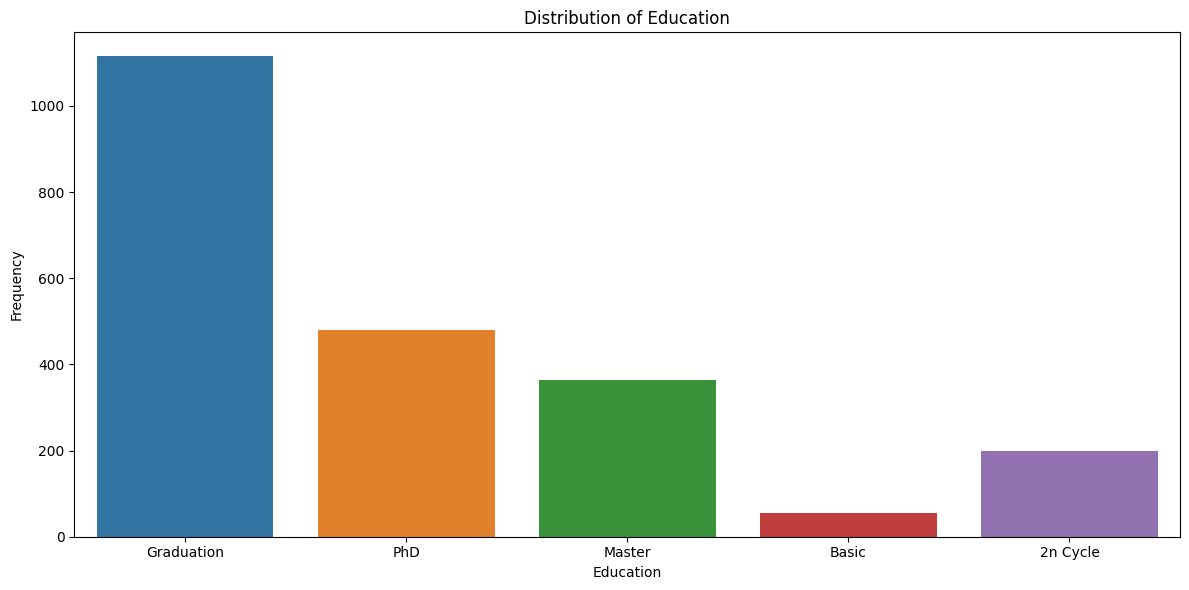

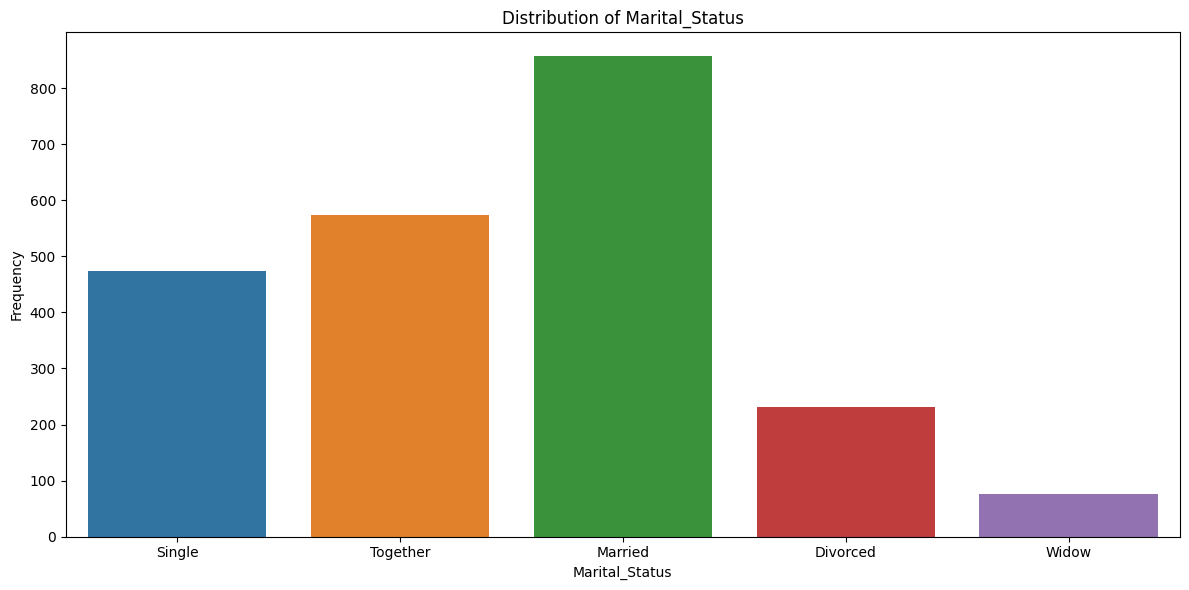

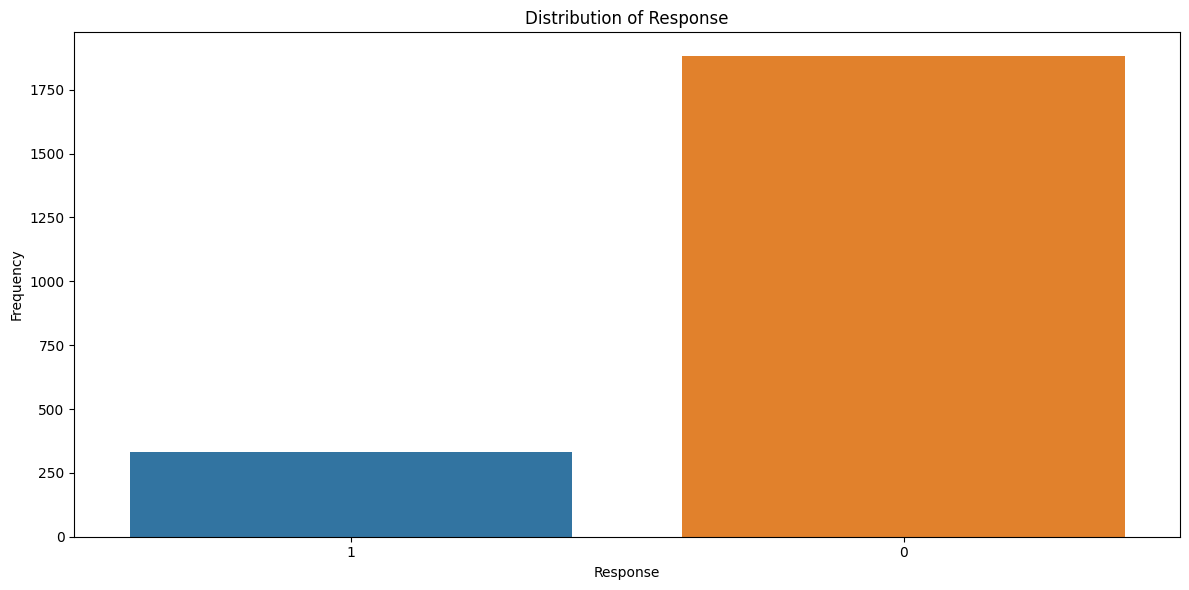

<Figure size 1200x600 with 0 Axes>

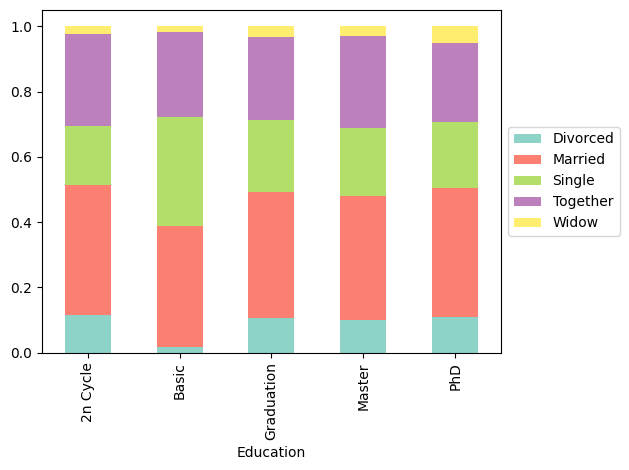

In [179]:
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')
df = df[~df['Marital_Status'].isin(['Absurd', 'YOLO'])]

for column in df.select_dtypes(include=['object']).columns.tolist():
    #print(f'{df[column].value_counts()}\n\n')
    plt.figure(figsize=(12, 6))  
    sns.countplot(data=df, x=column, hue=column, palette="tab10", legend=False)  # Explicitly set hue=column
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 6))
df_plot = df.groupby(['Marital_Status', 'Education']).size().reset_index().pivot(columns='Marital_Status', index='Education', values=0)
df_plot.apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True,  colormap='Set3')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()

['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']


/tmp/ipykernel_4851/1833820235.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percentage.reset_index(), x=var, y=target, palette='tab10')


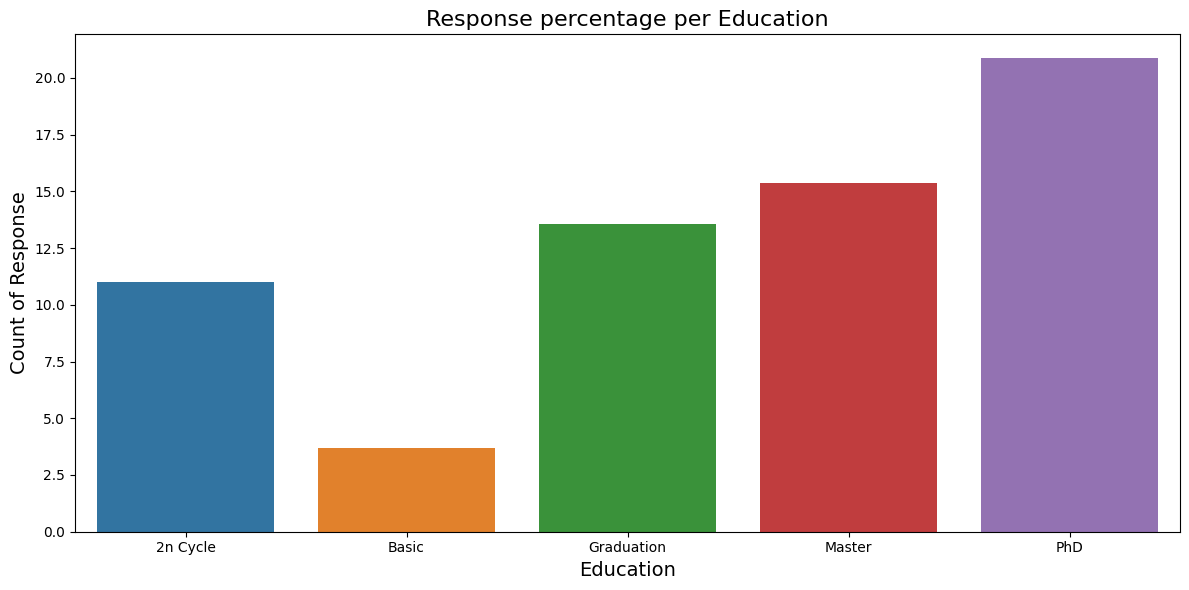

/tmp/ipykernel_4851/1833820235.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percentage.reset_index(), x=var, y=target, palette='tab10')


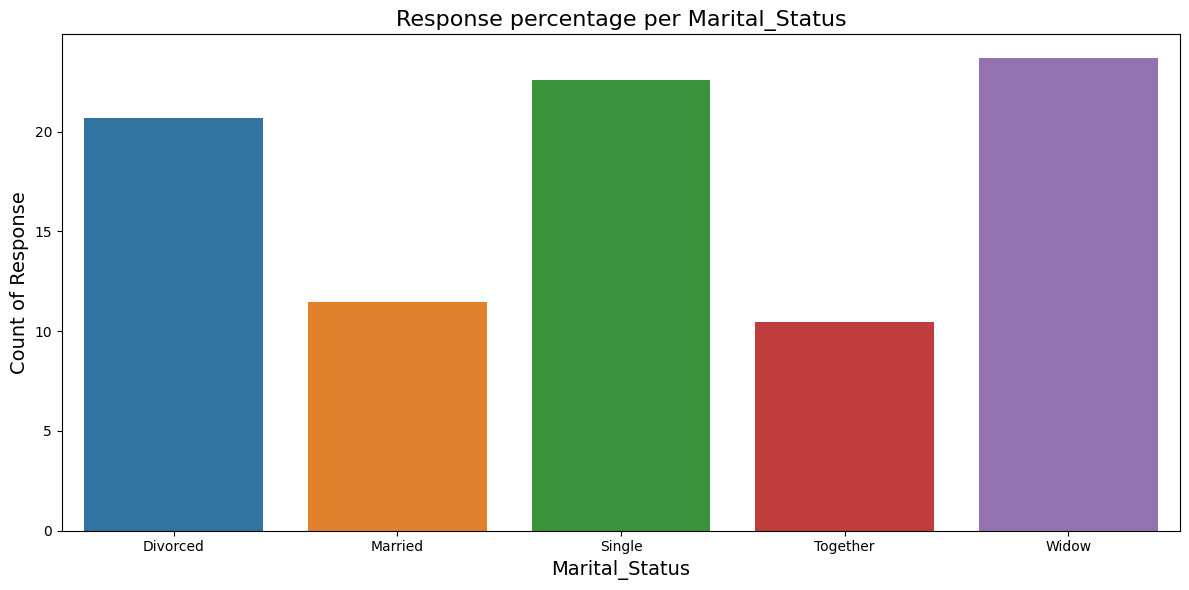

/tmp/ipykernel_4851/1833820235.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percentage.reset_index(), x=var, y=target, palette='tab10')


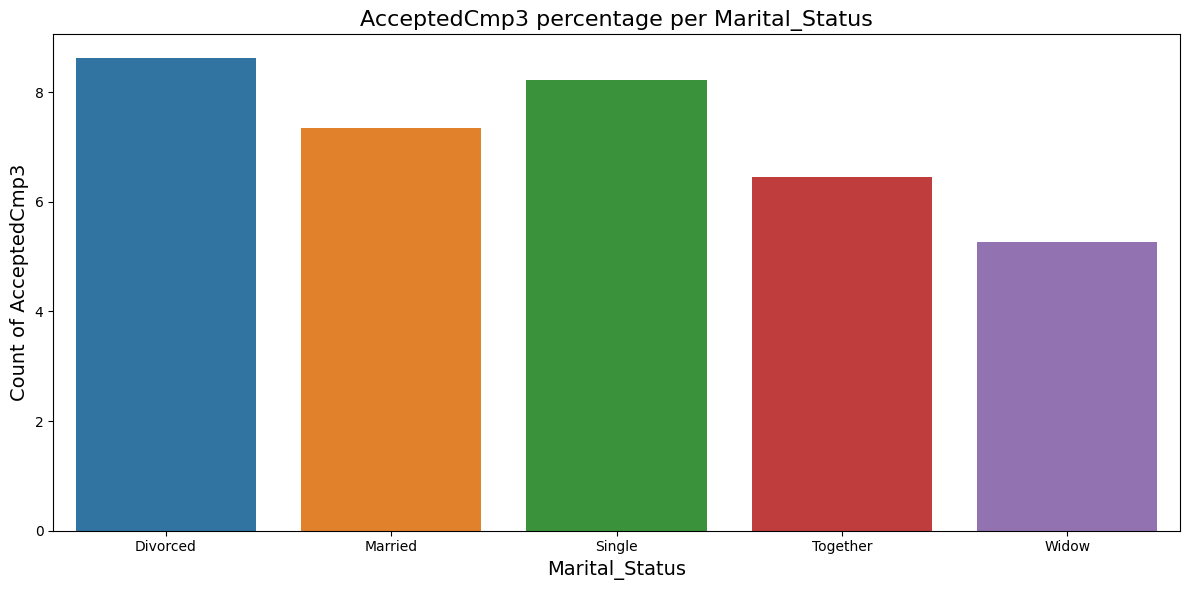

/tmp/ipykernel_4851/1833820235.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percentage.reset_index(), x=var, y=target, palette='tab10')


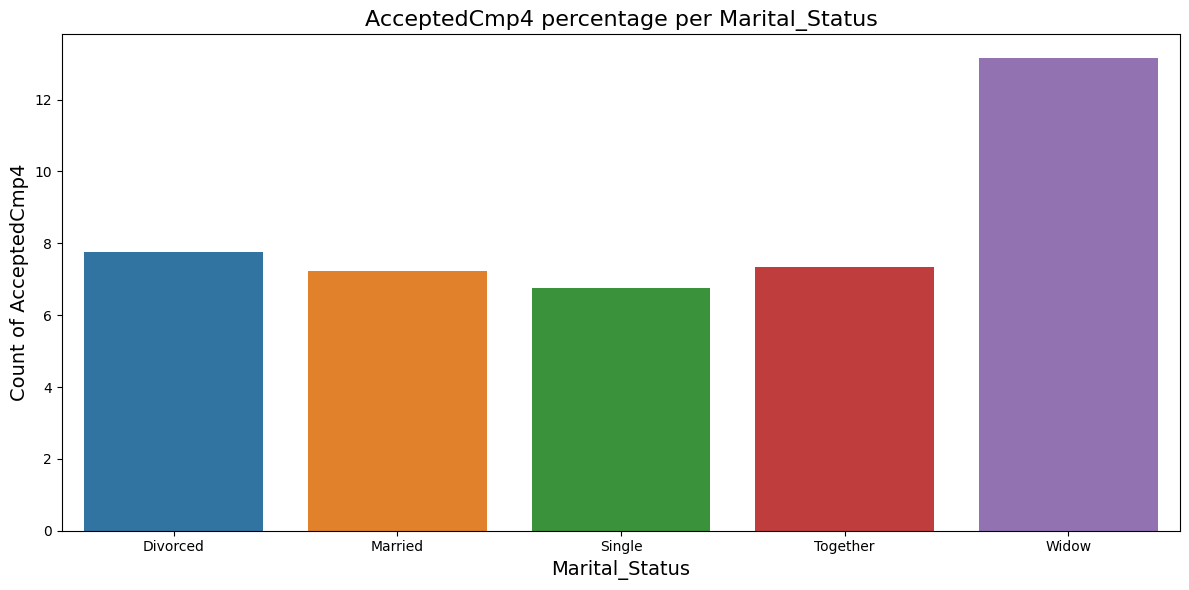

/tmp/ipykernel_4851/1833820235.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percentage.reset_index(), x=var, y=target, palette='tab10')


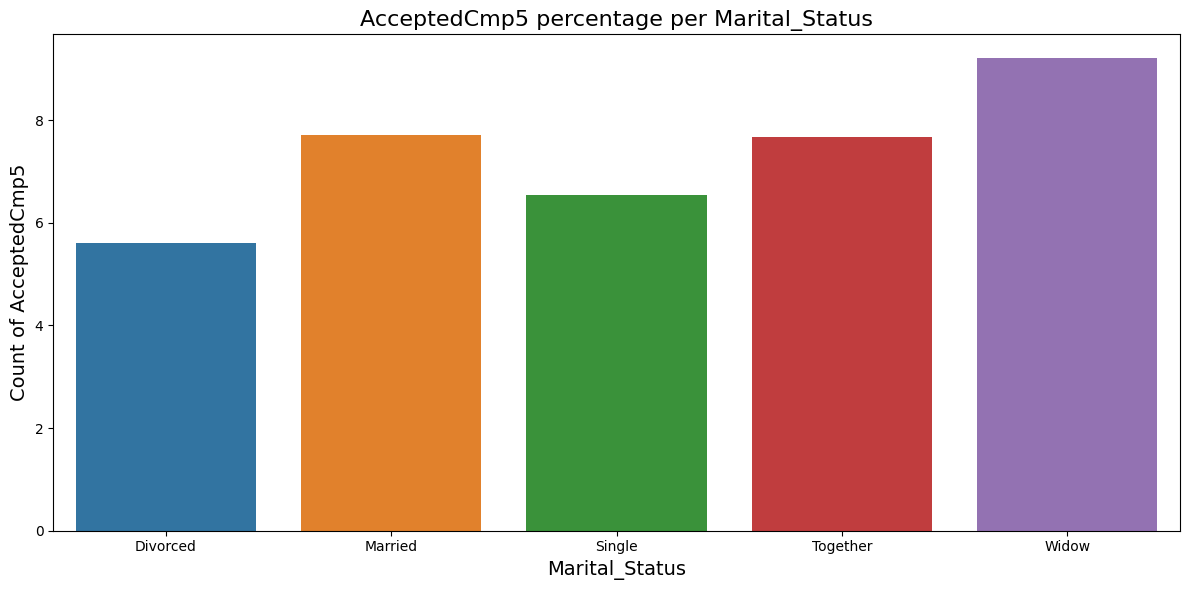

/tmp/ipykernel_4851/1833820235.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percentage.reset_index(), x=var, y=target, palette='tab10')


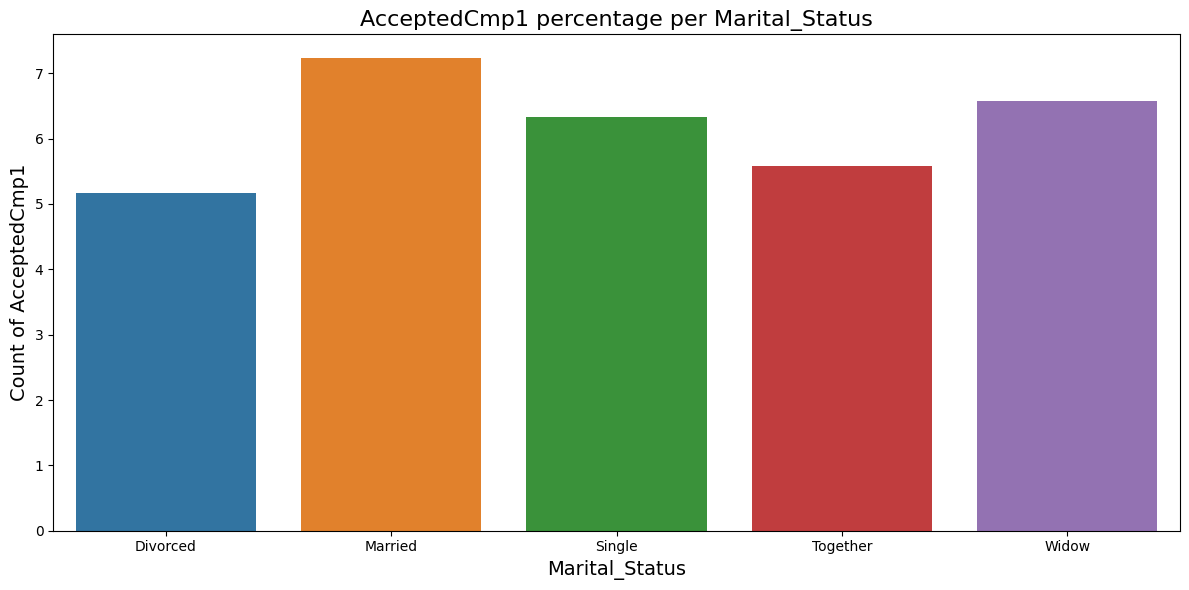

/tmp/ipykernel_4851/1833820235.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percentage.reset_index(), x=var, y=target, palette='tab10')


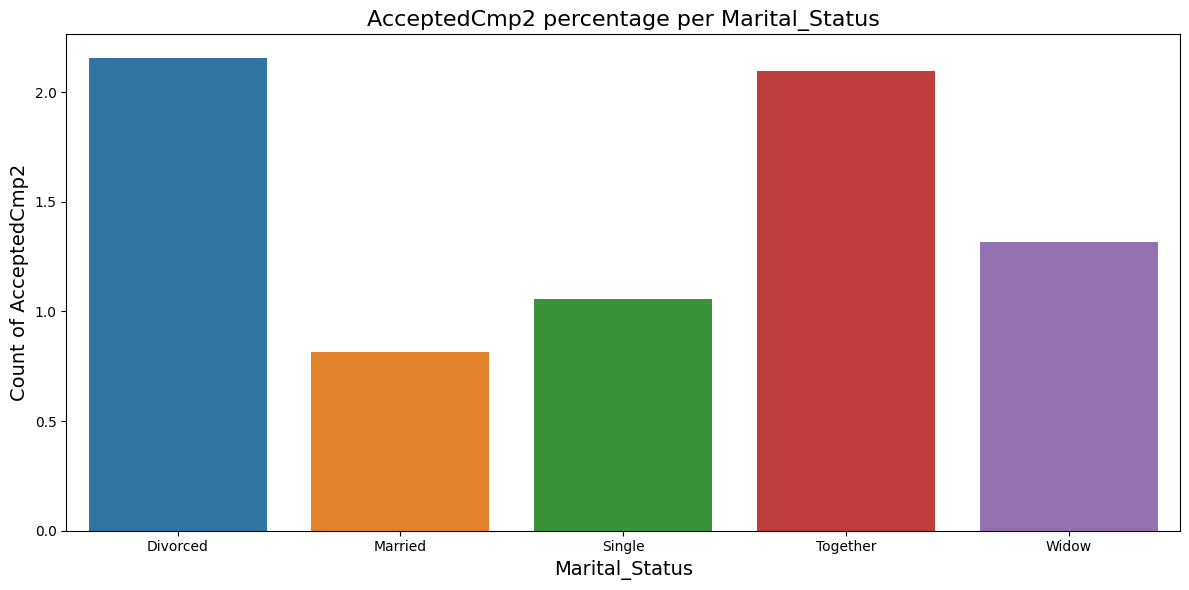

In [180]:
# convert all binaries into 'Int8' variable
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
df[binary_cols] = df[binary_cols].astype('Int8')
print(binary_cols)

def percent_plot(var:str, data:pd.DataFrame, target:str):
    """
    Function to calculate the percentage of response based on a specified variable in a DataFrame.

    Args:
        var (str): The name of the column to analyze in the DataFrame.
        data (pd.DataFrame): The DataFrame containing the data to analyze.

    Returns:
        float: The percentage of response in the specified column.
    """
    total = data.groupby(var).count()[target]
    counts = data[data[target] == 1].groupby(var)[target].count()
    percentage = (counts / total) * 100

    plt.figure(figsize=(12, 6))  
    sns.barplot(data=percentage.reset_index(), x=var, y=target, palette='tab10')

    plt.title(f"{target} percentage per {var}", fontsize=16)
    plt.xlabel(f"{var}", fontsize=14)
    plt.ylabel(f"Count of {target}", fontsize=14)

    plt.tight_layout()
    plt.show()


    # plt.figure(figsize=(12, 6))
    # percentage.plot(kind='bar', color='skyblue', edgecolor='black')
    # plt.title(f"{target} percentage per {var}", fontsize=16)
    # plt.xlabel(f"{var}", fontsize=14)
    # plt.ylabel(f"Count of {target}", fontsize=14)
    # plt.xticks(rotation=45, fontsize=12)
    # plt.yticks(fontsize=12)
    # plt.grid(axis='y', linestyle='--', alpha=0.7)

    # plt.tight_layout()
    # plt.show()

old_cmp = [col for col in df.columns if 'AcceptedCmp' in col]

for col in df.select_dtypes(include=['object']).columns.tolist():
    percent_plot(col, df, 'Response')

for col in old_cmp:
    percent_plot('Marital_Status', df, col)

# for col in old_cmp:
#     percent_plot('Education', df, col)    

In [181]:
old_cmp.append('Response')
total_response = df[old_cmp].sum(axis=1)

print(total_response.value_counts())

for col in old_cmp:
    print(f'\n{df[col].value_counts()}\n')

0    1609
1     368
2     139
3      50
4      36
5      10
Name: count, dtype: Int64

AcceptedCmp3
0    2049
1     163
Name: count, dtype: Int64


AcceptedCmp4
0    2048
1     164
Name: count, dtype: Int64


AcceptedCmp5
0    2051
1     161
Name: count, dtype: Int64


AcceptedCmp1
0    2071
1     141
Name: count, dtype: Int64


AcceptedCmp2
0    2182
1      30
Name: count, dtype: Int64


Response
0    1881
1     331
Name: count, dtype: Int64



In [182]:
def count_outliers(df, column, threshold=3):
    """
    Counts the number of outliers in a DataFrame column using the Z-score method.
    
    :param df: Pandas DataFrame
    :param column: Name of the column to analyze
    :param threshold: Z-score threshold to consider a value as an outlier (default is 3)
    :return: Number of outliers
    """
    if column not in df.columns:
        raise ValueError(f"The column '{column}' does not exist in the DataFrame.")
    
    mean = df[column].mean()
    std = df[column].std()
    
    if std == 0:
        return 0  # If the standard deviation is zero, there are no outliers
    
    z_scores = (df[column] - mean) / std
    outliers = df[np.abs(z_scores) > threshold]
    return len(outliers)

outlier_counts = {
    col: count_outliers(df, col, threshold=3)
    for col in df.select_dtypes(include=['float64']).columns
}

outlier_columns = [col for col, count in outlier_counts.items() if count > 0]
print(outlier_columns)



['Year_Birth', 'Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumWebVisitsMonth']


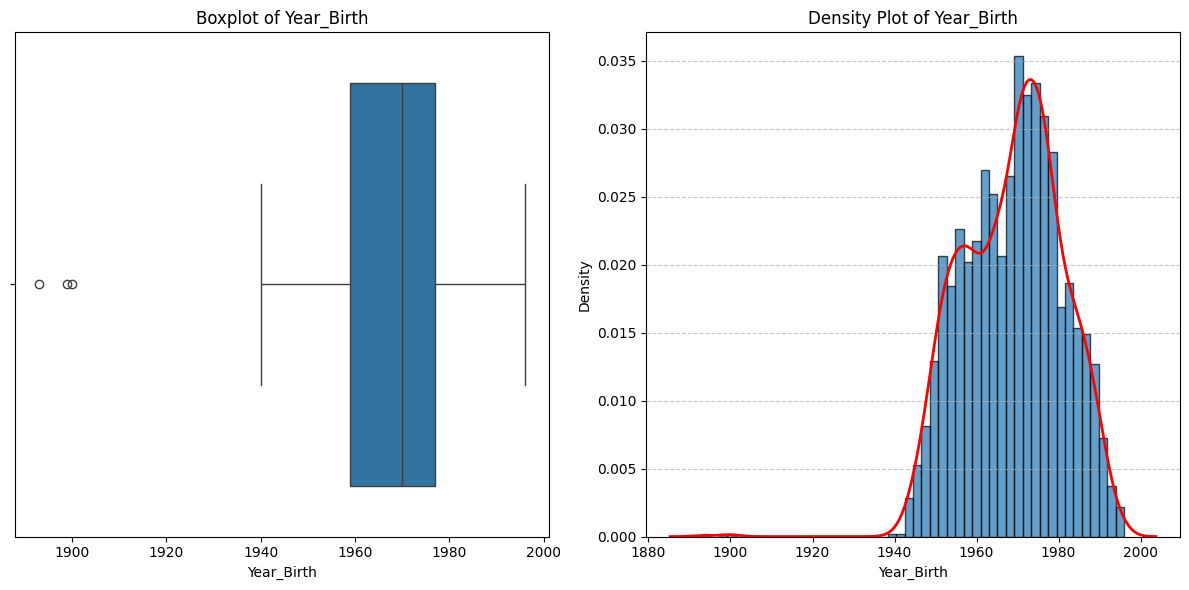

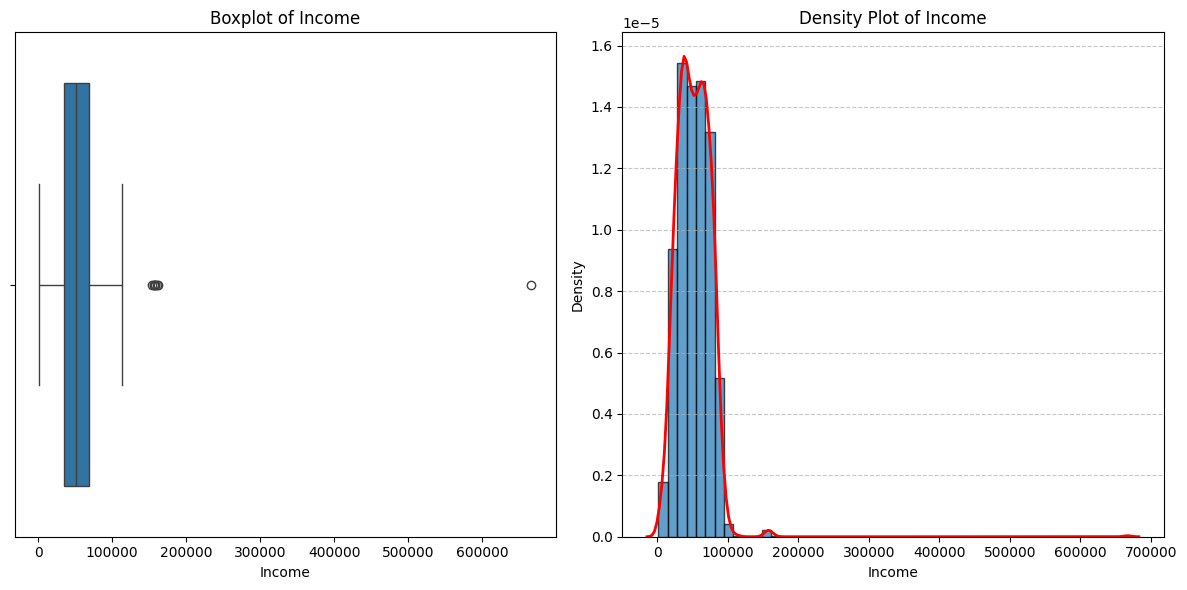

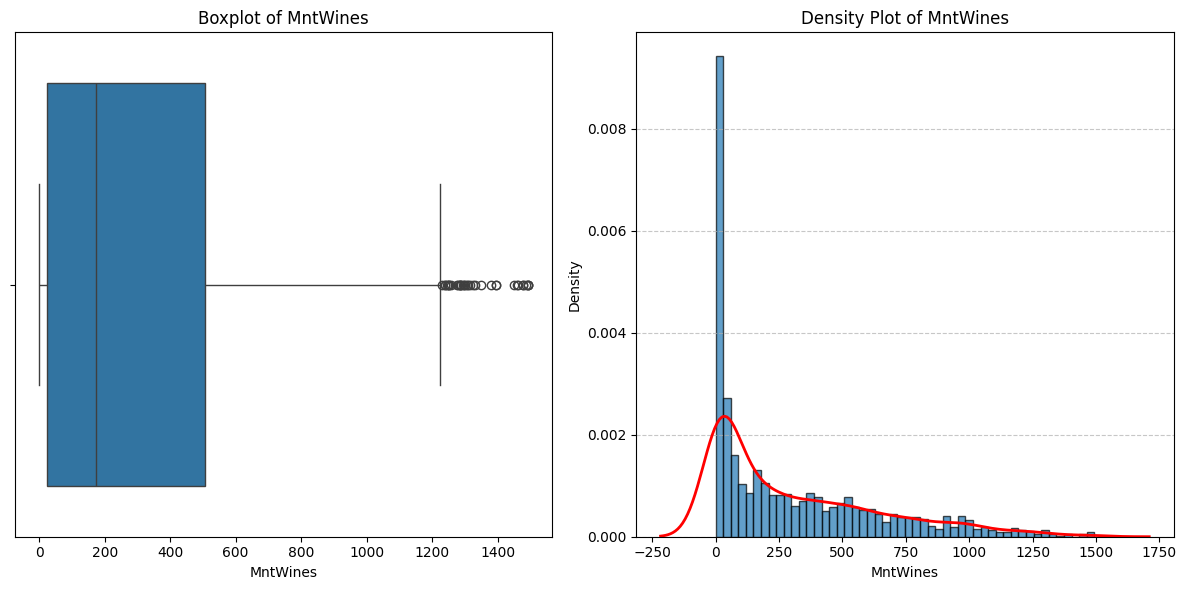

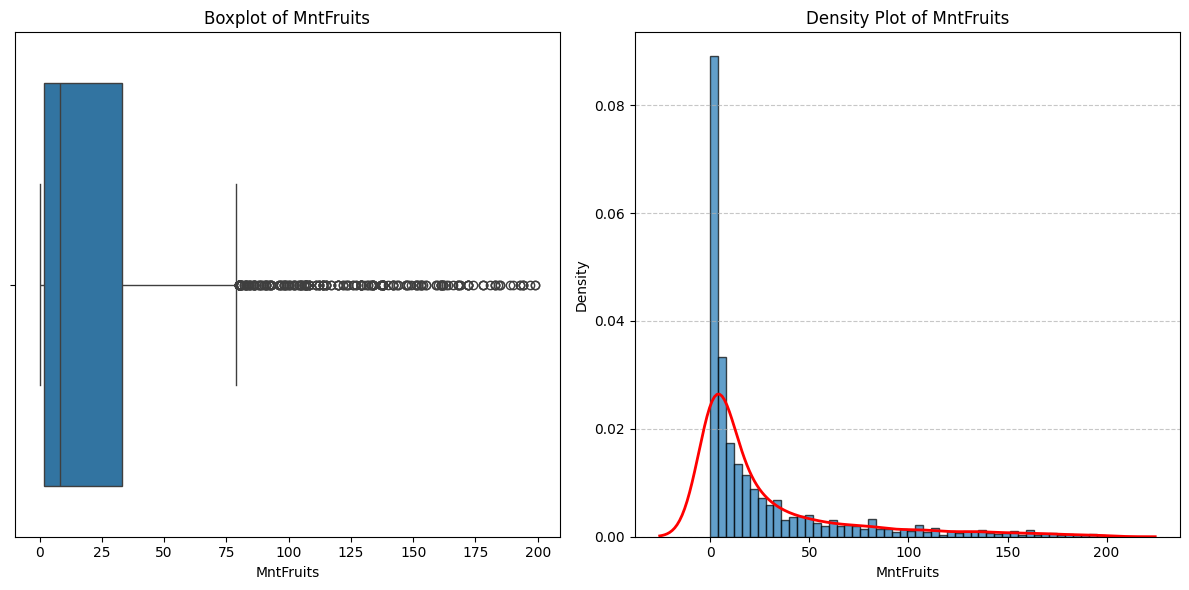

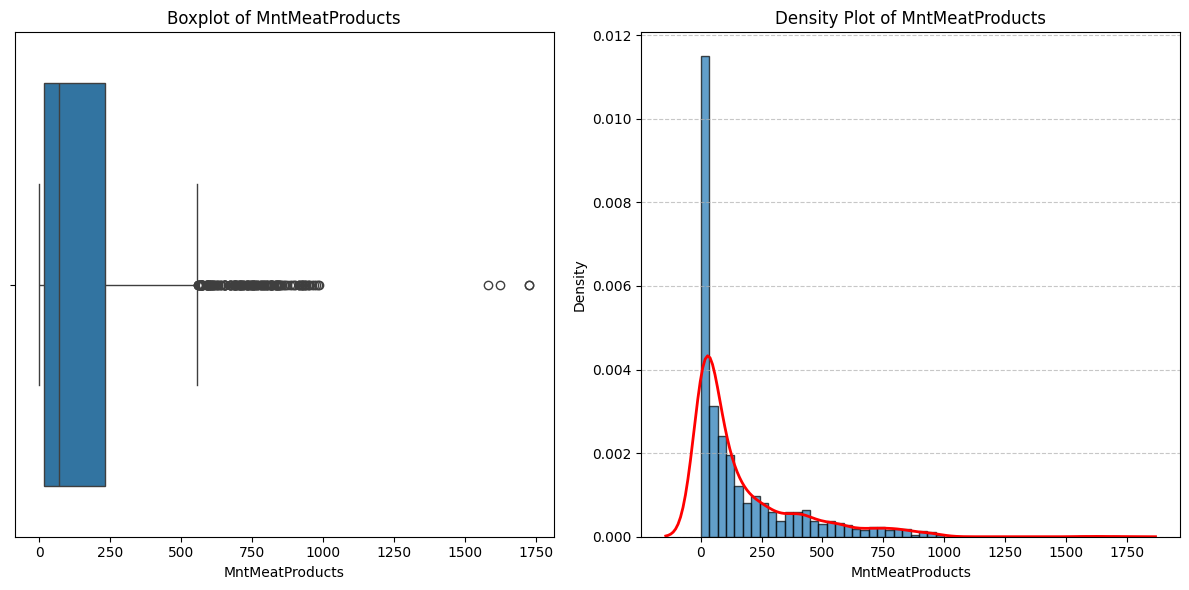

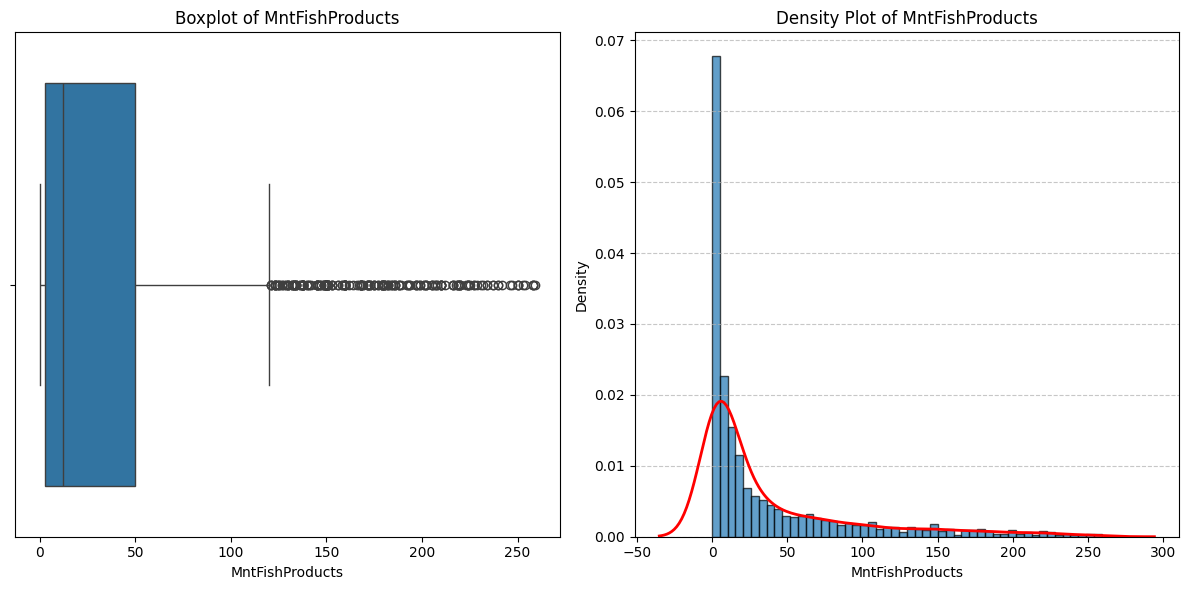

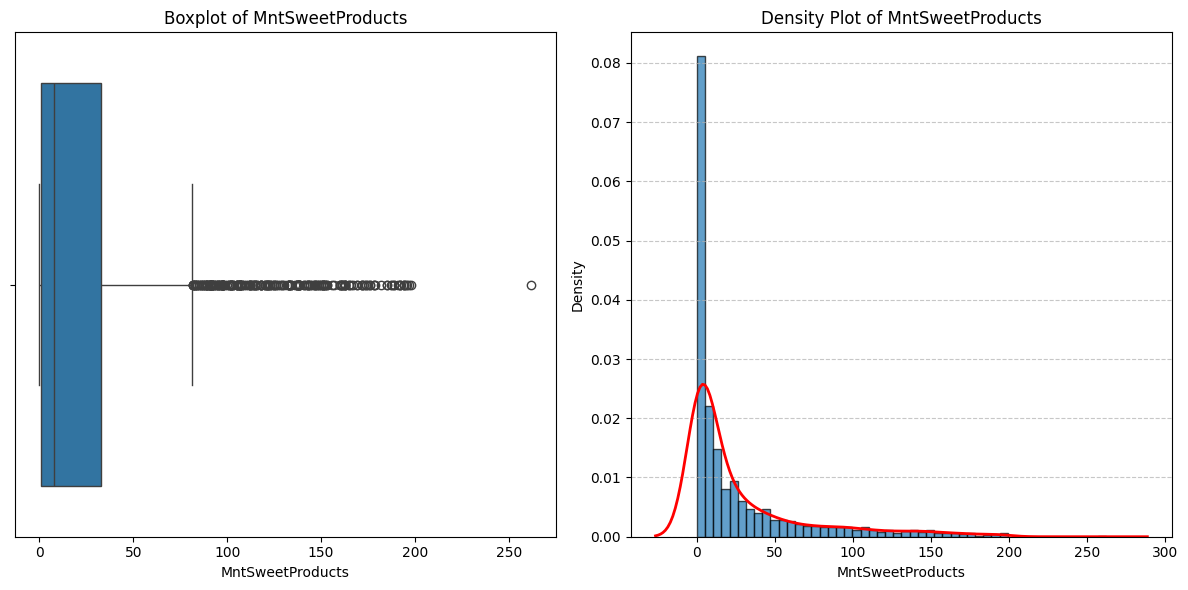

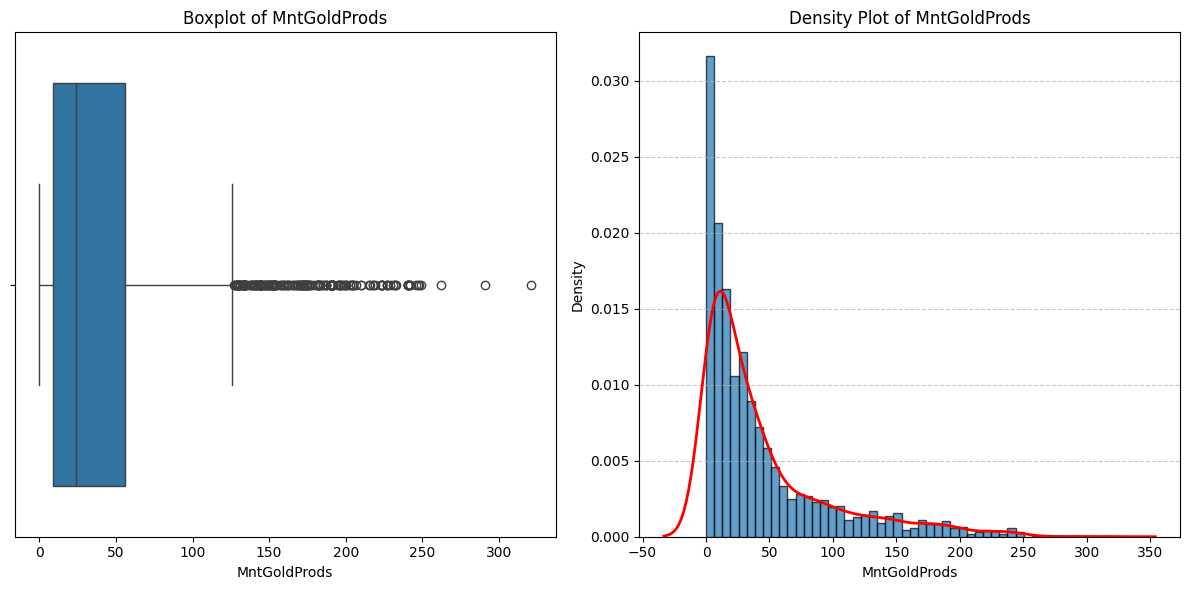

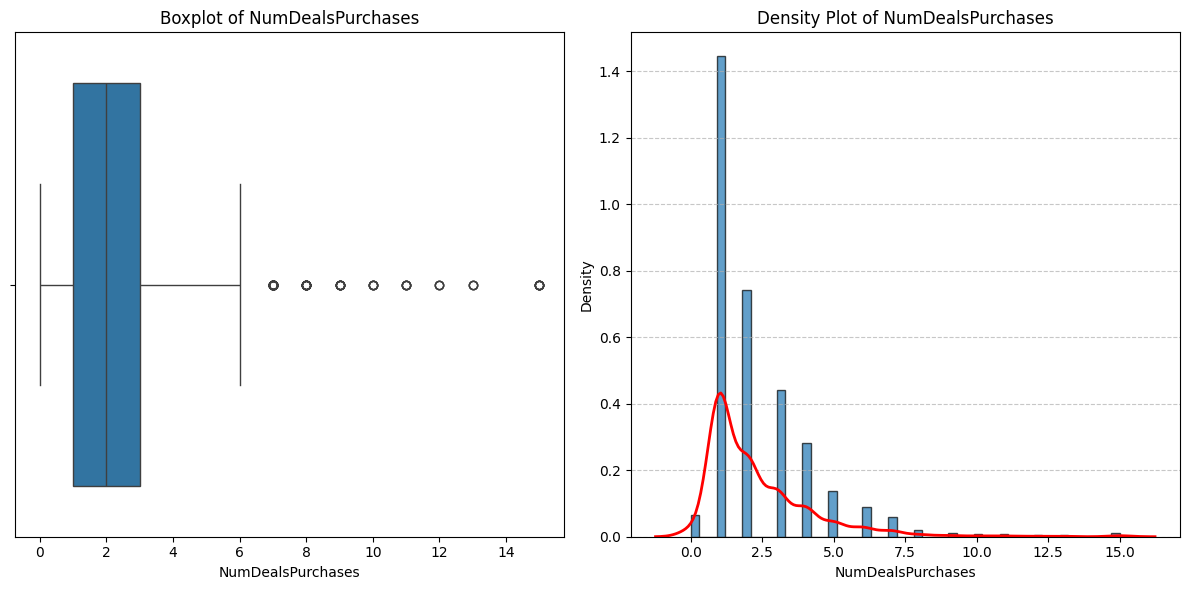

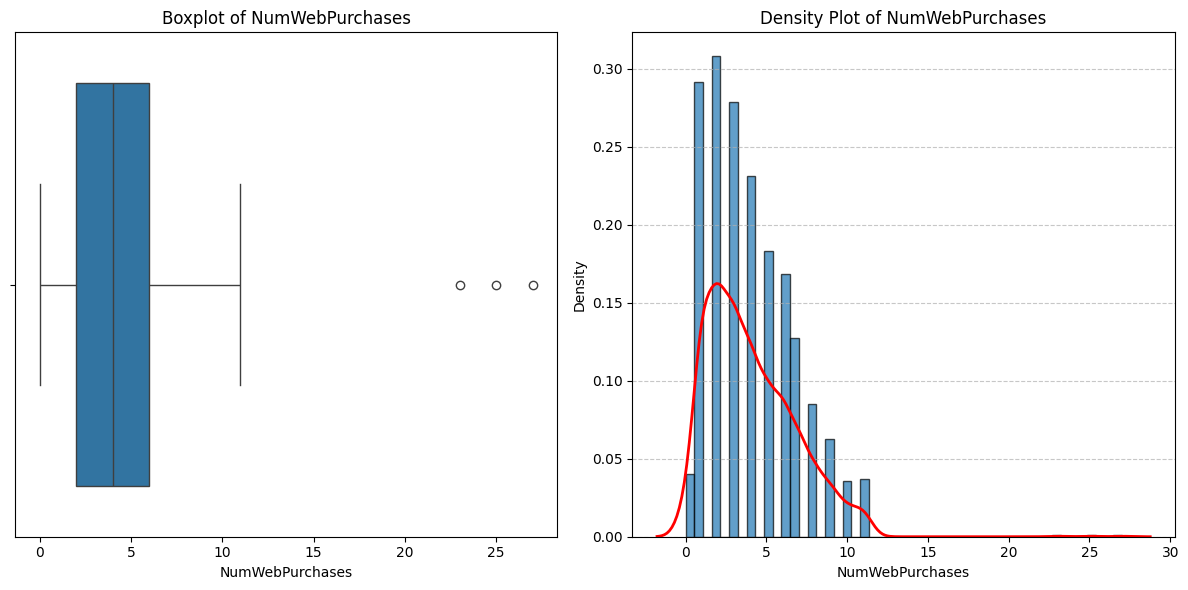

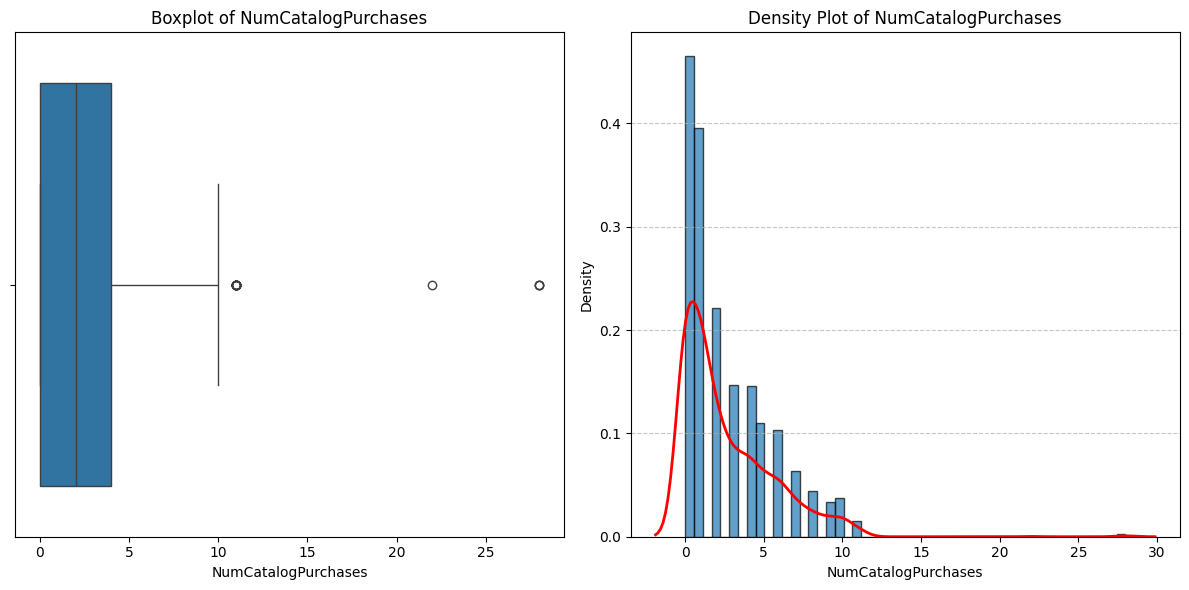

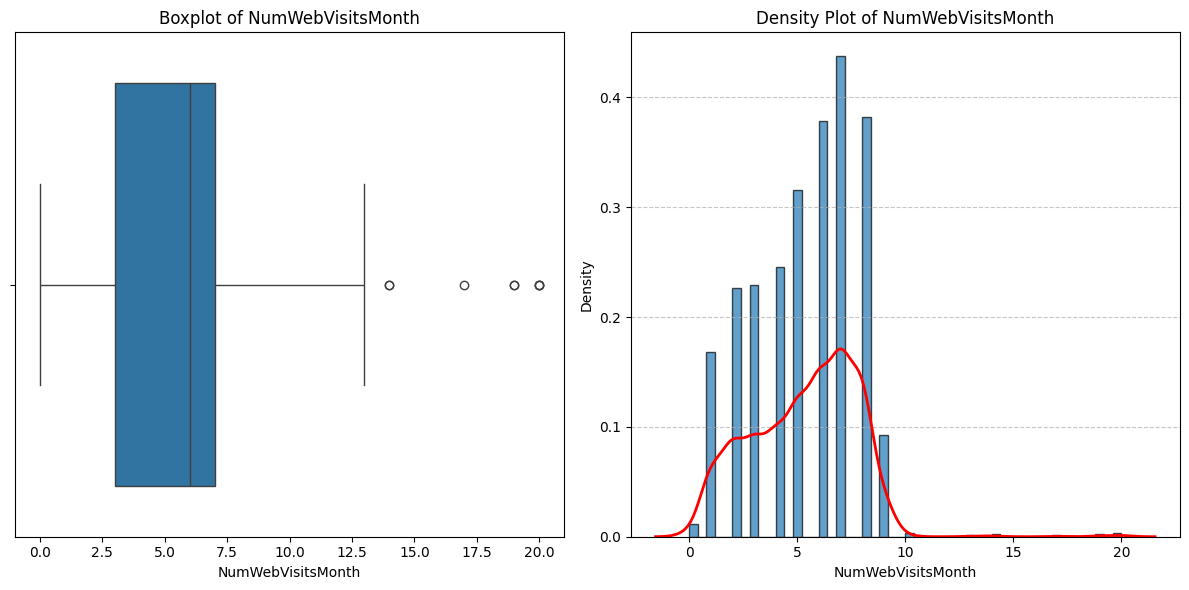

In [183]:
for col in outlier_columns:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.subplot(1, 2, 2)
    plt.hist(df[col], bins=50, edgecolor='black', alpha=0.7, density=True)
    sns.kdeplot(df[col], color='red', linewidth=2)
    plt.title(f'Density Plot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [184]:
other_cols = [col for col in df.columns if col not in binary_cols and col not in outlier_columns]

print(other_cols)

['ID', 'Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'Recency', 'NumStorePurchases', 'Z_CostContact', 'Z_Revenue', 'Customer_Age']


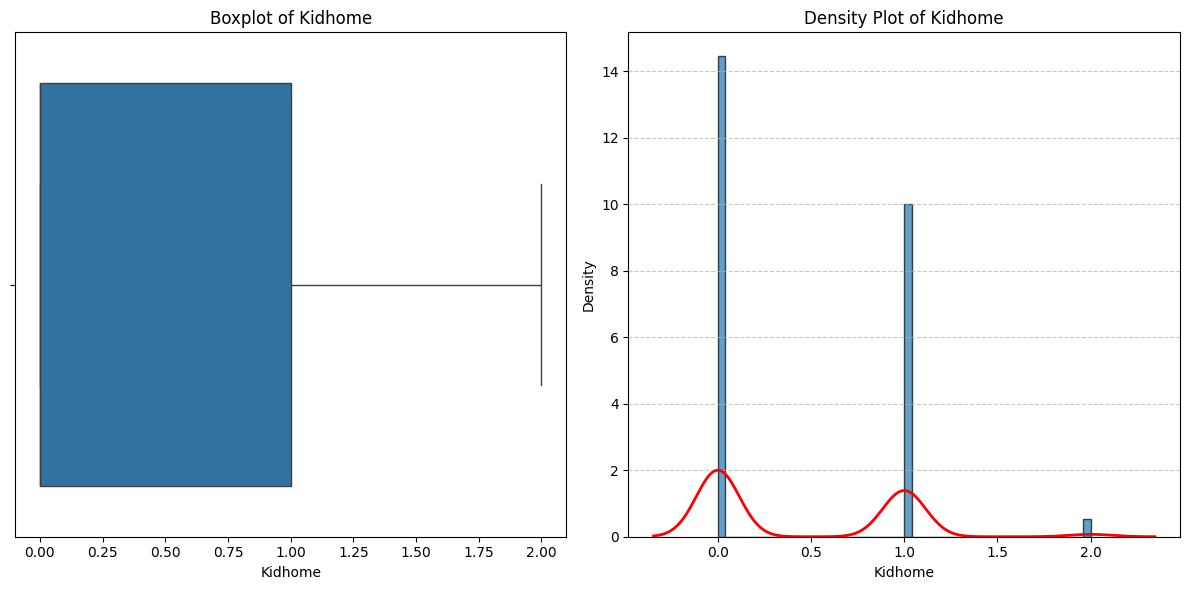

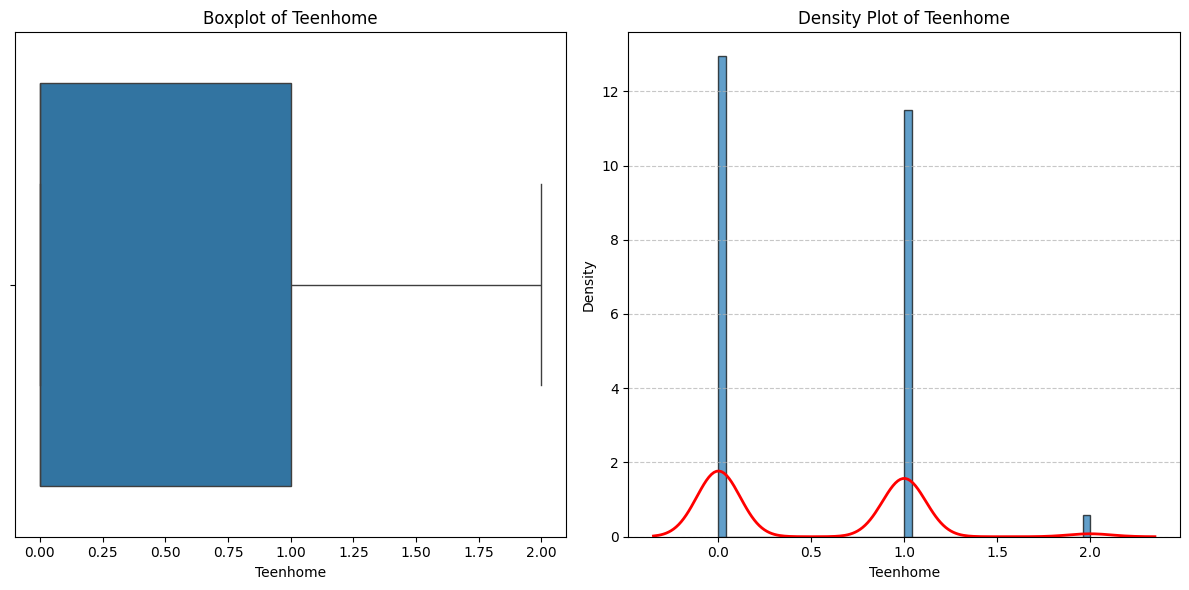

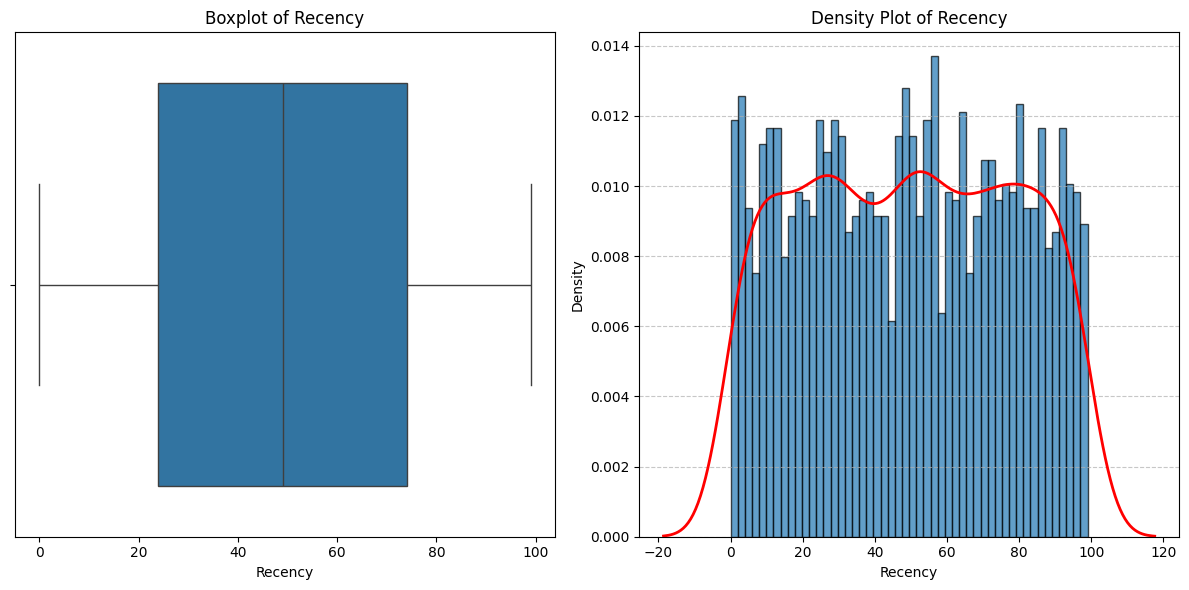

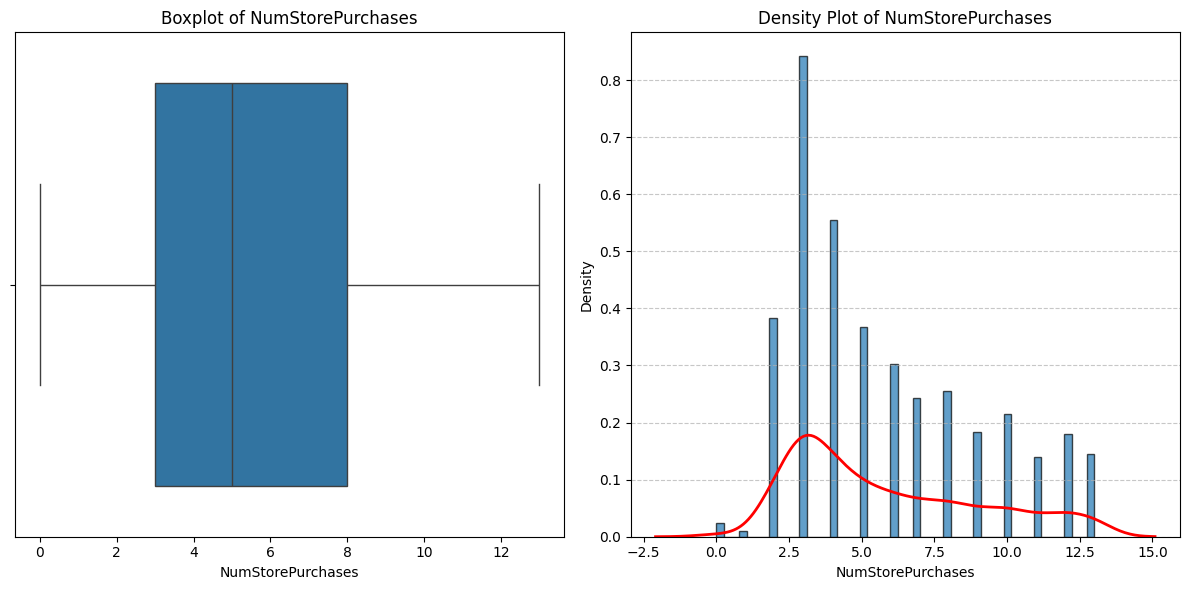

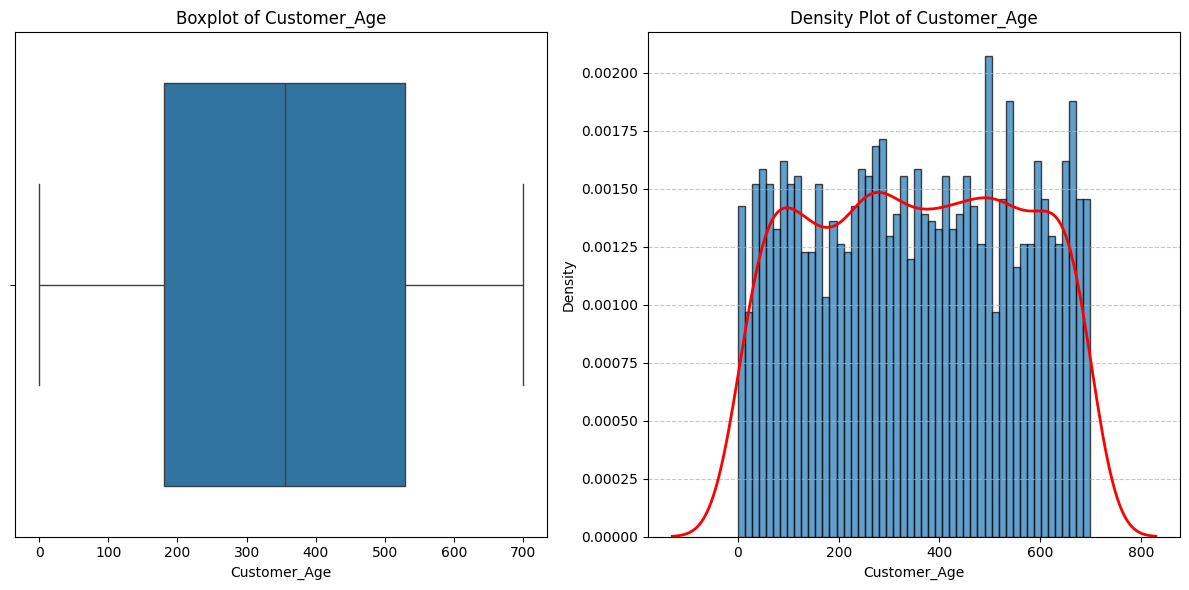

In [185]:
for col in ['Kidhome', 'Teenhome', 'Recency', 'NumStorePurchases','Customer_Age']:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.subplot(1, 2, 2)
    plt.hist(df[col], bins=50, edgecolor='black', alpha=0.7, density=True)
    sns.kdeplot(df[col], color='red', linewidth=2)
    plt.title(f'Density Plot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

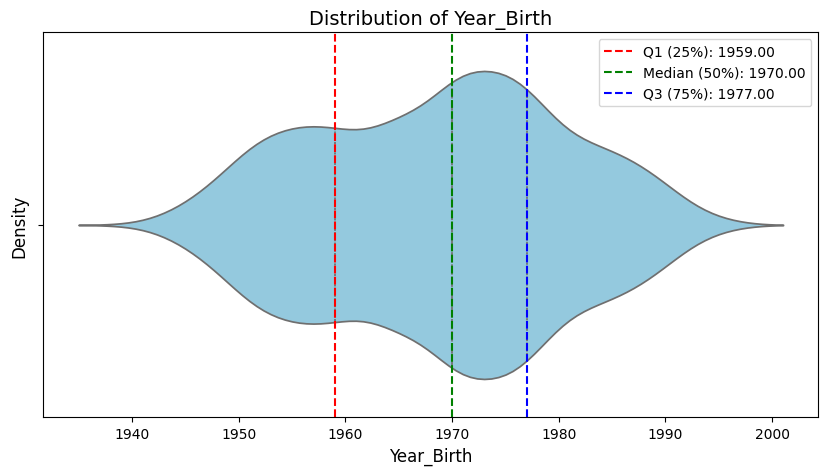

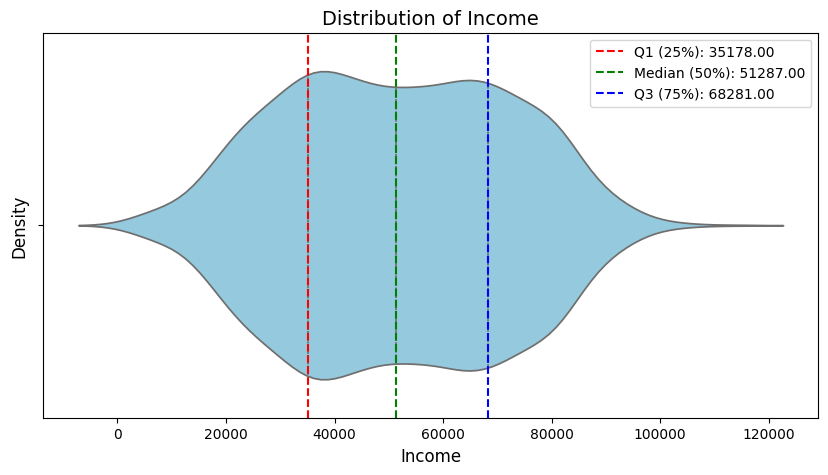

In [186]:
def remove_outliers(df, columns, threshold=3):
    """
    Removes outliers from the specified columns in a DataFrame using the Z-score method.
    
    :param df: Pandas DataFrame
    :param columns: List of column names to analyze
    :param threshold: Z-score threshold to consider a value as an outlier (default is 3)
    :return: DataFrame with outliers removed
    """
    df_clean = df.copy()
    for column in columns:
        if column in df_clean.columns:
            mean = df_clean[column].mean()
            std = df_clean[column].std()
            
            if std == 0:
                continue  # Skip if standard deviation is zero
            
            z_scores = (df_clean[column] - mean) / std
            df_clean = df_clean[np.abs(z_scores) <= threshold]
    
    return df_clean

df = remove_outliers(df, ['Year_Birth', 'Income'])

for col in ['Year_Birth', 'Income']:
    plt.figure(figsize=(10, 5))

    q25, q50, q75 = np.percentile(df[col], [25, 50, 75])

    sns.violinplot(x=df[col], inner="quartile", color="skyblue")

    plt.axvline(q25, color='red', linestyle='dashed', label=f"Q1 (25%): {q25:.2f}")
    plt.axvline(q50, color='green', linestyle='dashed', label=f"Median (50%): {q50:.2f}")
    plt.axvline(q75, color='blue', linestyle='dashed', label=f"Q3 (75%): {q75:.2f}")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.legend()
    plt.show()




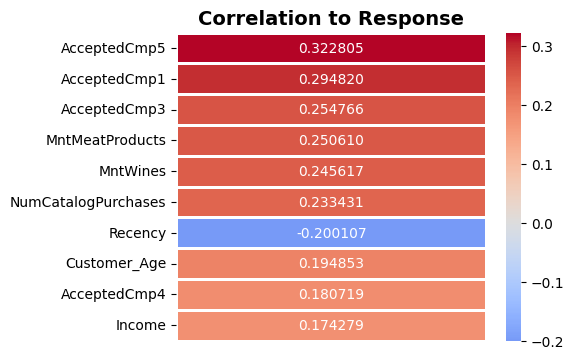

In [197]:
def plot_top_correlations(df, target_var, top_n=5):
    """
    Affiche les variables les plus corrélées avec une variable cible sous forme de heatmap horizontale.

    :param df: DataFrame contenant les données.
    :param target_var: La variable cible dont on veut voir les corrélations.
    :param top_n: Nombre de variables les plus corrélées à afficher.
    """
    # Calculer la corrélation avec la variable cible et trier par valeur absolue (sans supprimer le signe)
    correlations = df.corr()[target_var].drop(target_var).sort_values(key=abs, ascending=False).head(top_n)

    # Création de la heatmap
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(correlations.to_frame(), annot=True, cmap="coolwarm", linewidths=2, fmt=".6f",
                cbar=True, ax=ax, xticklabels=False, yticklabels=True, center=0)

    ax.set_title(f"Correlation to {target_var}", fontsize=14, fontweight="bold")
    ax.set_ylabel("")
    plt.show()

# Sélection des variables numériques
df_corr = df.select_dtypes(include=['float64', 'int64', 'Int8'])
plot_top_correlations(df_corr, 'Response', top_n=10)


In [ ]:
df.columns

-On va laisser l'année car je n'ai pas trouver d'info précise sur la date du dataset, et nous allons standardizer les données plus tard.

-Nous avons gardé les valeurs aberrantes pour les variables de montants dépensés car elles seront utiles pour la segmentation.

In [ ]:
df.dtypes

# Data Normalisation before customer segmentation and models training

In [ ]:
print(list(df.columns))

In [189]:
def test_pareto_distribution(df, column):
    """
    Effectue un test d'hypothèse pour vérifier si une colonne suit une loi de Pareto.
    
    :param df: DataFrame pandas
    :param column: Nom de la colonne à tester
    :return: D-statistique et p-value du test de Kolmogorov-Smirnov
    """
    shape, loc, scale = stats.pareto.fit(df[column])
    D, p_value = stats.kstest(df[column], 'pareto', args=(shape, loc, scale))
    
    return {"column": column, "D-statistic": D, "p-value": p_value, "is_pareto": p_value > 0.05}

pareto_feature = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases']

results = [test_pareto_distribution(df, col) for col in pareto_feature]

import pandas as pd
df_results = pd.DataFrame(results)
df_results

,column,D-statistic,p-value,is_pareto
0,MntWines,0.148507,7.763922e-43,False
1,MntFruits,0.178555,7.327400e-62,False
2,MntMeatProducts,0.085464,1.954458e-14,False
3,MntFishProducts,0.172194,1.553823e-57,False
4,MntSweetProducts,0.186279,2.478349e-67,False
5,MntGoldProds,0.040502,1.420126e-03,False
6,NumDealsPurchases,0.332901,6.363340e-218,False


In [ ]:
# truncated_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases']
# from sklearn.preprocessing import PowerTransformer

# # pt = PowerTransformer(method='yeo-johnson')
# # df[truncated_features] = pt.fit_transform(df[truncated_features])

# #df_pareto_log = np.log1p(df[pareto_feature])

# # scaler_standard = StandardScaler()
# # df_pareto_standard = scaler_standard.fit_transform(df_pareto_log)

# #df[pareto_feature] = truncated_features#df_pareto_standard

# for col in pareto_feature:
#     plt.figure(figsize=(10, 5))
#     plt.hist(df[col], bins=50, edgecolor='black', alpha=0.7, density=True)  # Ajout de density=True
#     # distribution (Kernel Density Estimate)
#     #sns.kdeplot(df[col], color='red', linewidth=2)
#     plt.xlabel(col)
#     plt.ylabel("Density")
#     plt.title(f"Distribution of {col}")
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.show()

In [190]:
df = pd.get_dummies(df, drop_first=True, dtype='Int8')
df.drop(columns=['Z_CostContact', 'Z_Revenue', 'ID'], inplace=True)

In [191]:
def standardize_columns(df, columns):
    """
    Standardize specified columns in a DataFrame using their mean and standard deviation.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to standardize.

    Returns:
        pd.DataFrame: A copy of the DataFrame with the specified columns standardized.
        dict: A dictionary containing the mean and standard deviation for each standardized column.
    """
    scaler = StandardScaler()
    df_copy = df.copy()
    df_copy[columns] = scaler.fit_transform(df[columns])
    stats = {
        col: {"mean": scaler.mean_[i], "std": scaler.scale_[i]} 
        for i, col in enumerate(columns)
    }
    return df_copy, stats

def standardize_test_data(df, columns, stats):
    """
    Standardize specified columns in a test DataFrame using the provided mean and standard deviation.

    Args:
        df (pd.DataFrame): The test DataFrame to be standardized.
        columns (list): A list of column names to standardize.
        stats (dict): A dictionary containing the mean and standard deviation for each column 
                      (from the training dataset).

    Returns:
        pd.DataFrame: A copy of the test DataFrame with the specified columns standardized.
    """
    df_copy = df.copy()
    for col in columns:
        if col not in stats:
            raise ValueError(f"Statistics for column '{col}' not found in the provided stats.")
        if col not in df_copy.columns:
            raise ValueError(f"Column '{col}' not found in the test DataFrame.")
        
        mean = stats[col]["mean"]
        std = stats[col]["std"]
        
        df_copy[col] = (df_copy[col] - mean) / std

    return df_copy


def numeric_columns(df: pd.DataFrame, dtype: str='Int8') -> list:
    """
    Retourne le nom des colonnes numériques d'un DataFrame.
    
    Args:
    df : pd.DataFrame
        Le DataFrame dont on souhaite obtenir les colonnes numériques.
        
    Returns:
    list
        Liste des noms des colonnes numériques.
    """
    return df.select_dtypes(include=[dtype]).columns.tolist()

In [ ]:
# Standardize numeric columns and save means and std in a new df to apply SOM
# Warning: Si plus tard on utilise les résultats du SOM, il faudra déjà séparer en test et entrainement.
# Ici je le fais seulement pour tester SOM

col_names = [col for col in df.columns if col not in numeric_columns(df, dtype='Int8')]
df_som, param_stand = standardize_columns(df, col_names)
#X_test = standardize_test_data(X_test, col_names, param_stand)
stats = pd.DataFrame({
    'Mean': df_som.mean(),
    'Variance': df_som.var()
})
print(stats)

In [ ]:
df_som.to_csv('data_clean.csv')

# Segmentation with SOM

In [ ]:
!pip install rpy2

In [ ]:
# Activer R dans le notebook
%load_ext rpy2.ipython

In [ ]:
%%R
# Charger les librairies
install.packages("tidyr")
install.packages("dplyr")
install.packages("cluster")
install.packages("kohonen")
install.packages("caret")
install.packages("randomForest")
install.packages("gbm")
install.packages("pROC")

library(tidyr)
library(dplyr)
library(cluster)
library(kohonen)
library(caret)
library(randomForest)
library(gbm)
library(pROC)


In [ ]:
%%R

# Charger les données
df_som <- read.csv("marketing_campaign.csv", sep=";")

# Statistiques descriptives
summary(df_som)

# Sélection des variables pour segmentation
features <- c("Income", "Kidhome", "Teenhome", "MntWines", "MntFruits",
              "MntMeatProducts", "MntFishProducts", "NumWebPurchases",
              "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth")

# Normalisation des données
df_clean <- df_som %>% select(all_of(features)) %>% na.omit()
df_scaled <- as.data.frame(scale(df_clean))


In [ ]:
%%R
set.seed(1234)
# Création du SOM
som_grid <- somgrid(xdim = 12, ydim = 12, topo = "hexagonal")
som_model <- som(as.matrix(df_scaled), grid = som_grid, rlen = 100)

# Affichage des clusters SOM
plot(som_model, type="mapping", main="Carte SOM avec clusters")

# Affichage du nombre d'observations par cluster
plot(som_model, type="count", main="Nombre d'observations par cluster")

# Affichage des codes SOM (représentation des attributs dans chaque cluster)
plot(som_model, type="codes", main="Clusters SOM avec attributs")


In [ ]:
%%R
# Boucle pour créer les heatmaps
for (var in features) {
  plot(som_model, type = "property", property = df_scaled[[var]],
       main = paste("Distribution de", var))
}


In [ ]:
%%R

set.seed(1234)
library(cluster)

sil_scores <- numeric(10)
for (k in 2:10) {
  som_codes <- as.matrix(som_model$codes[[1]])
  km <- kmeans(som_codes, centers = k, nstart = 10)
  sil <- silhouette(km$cluster, dist(som_codes))
  sil_scores[k] <- mean(sil[, 3])
}

plot(2:10, sil_scores[2:10], type = "b", pch = 19, frame = FALSE,
     xlab = "Nombre de clusters K", ylab = "Indice de silhouette moyen",
     main = "Indice de Silhouette pour choisir K")


In [ ]:
%%R
som_codes <- as.matrix(som_model$codes[[1]])  # Extraire la matrice des poids des neurones
som_cluster <- cutree(hclust(dist(som_codes)), k = 4)

# Affichage des clusters
plot(som_model, type = "codes", bgcol = som_cluster, main = "Clusters SOM")
add.cluster.boundaries(som_model, som_cluster)


In [ ]:
%%R
# Définition des couleurs des clusters
cluster_colors <- c("#77BB66", "#F37722", "#7799DD", "#FF99FF")

# Conversion en facteur pour s'assurer que l'ordre des couleurs est respecté
som_cluster <- factor(cutree(hclust(dist(som_codes)), k = 4))

# Ajustement des marges pour laisser de la place à la légende
par(mar = c(5, 4, 4, 5))  # Augmente la marge droite
par(oma = c(0, 0, 0, 6))  # Ajoute un espace externe à droite

# Définir une mise en page avec 2 parties (graphique + espace pour la légende)
layout(matrix(c(1, 2), ncol = 2), widths = c(3, 1))  # 3 parts pour le graph, 1 part pour la légende

# Affichage du SOM avec les couleurs personnalisées
plot(som_model, type = "codes", bgcol = cluster_colors[som_cluster], main = "Clusters SOM")

# Ajout des frontières des clusters
add.cluster.boundaries(som_model, som_cluster)

# Passer à l’espace dédié à la légende
par(mar = c(0, 0, 0, 0))  # Supprimer les marges pour bien aligner la légende
plot.new()  # Créer un plot vide pour placer la légende

# Afficher la légende complètement à droite, sans chevauchement
legend("center", legend = paste("Cluster", levels(som_cluster)),
       fill = cluster_colors, title = "Clusters", border = "black", bty = "n")


In [ ]:
%%R
df_som_clean <- df_som[complete.cases(df_som[, features]), ]  # Keep only the rows used in SOM

# Now we can safely add the cluster assignments
df_som_clean$Cluster <- som_cluster[som_model$unit.classif]

# Contingency table of clusters vs. subscription
table(df_som_clean$Cluster, df_som_clean$Response)

# Convert to proportions per cluster
prop.table(table(df_som_clean$Cluster, df_som_clean$Response), margin = 1)


In [ ]:
%%R
# Ensure df_som_clean has the correct number of rows
df_som_clean <- df_som[complete.cases(df_som[, features]), ]

# Assign cluster labels to observations
df_som_clean$Cluster <- som_cluster[som_model$unit.classif]

# Convert Cluster to factor
df_som_clean$Cluster <- as.factor(df_som_clean$Cluster)

# Generate dummy variables for Cluster
dummies <- model.matrix(~ Cluster - 1, data = df_som_clean)

# Convert to dataframe and rename columns
dummies_df <- as.data.frame(dummies)
colnames(dummies_df) <- paste0("Cluster_", levels(df_som_clean$Cluster))

# Create final df with only ID and cluster dummies
df_clusters <- cbind(df_som_clean["ID"], dummies_df)

# Display first rows
head(df_clusters, 15)


In [ ]:
import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri

# Activate the pandas2ri conversion
pandas2ri.activate()

# Fetch the R dataframe and convert it to Pandas
df_clusters = robjects.r['df_clusters']

pandas2ri.deactivate()

df_merged = pd.merge(df, df_clusters, on="ID", how="inner")
df = df_merged
df.head()


In [ ]:
import pandas as pd

def describe_clusters(df):
    """
    Affiche une description statistique des variables pour chaque cluster défini par Cluster_1 à Cluster_4.

    :param df: DataFrame contenant les colonnes 'Cluster_1' à 'Cluster_4' et d'autres variables numériques.
    """
    for i in range(1, 5):  # Pour Cluster_1 à Cluster_4
        cluster_col = f'Cluster_{i}'
        if cluster_col in df.columns:
            subset = df[df[cluster_col] == 1]  # Filtrer les lignes où Cluster_i == 1
            print(f"Description des variables pour {cluster_col} == 1:")
            print(subset.describe(), "\n")

# Exemple d'utilisation
# df = pd.read_csv("votre_fichier.csv")  # Charger votre dataset
describe_clusters(df)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_grid(df, cluster_cols, studied_vars):
    """
    Génère une grille de graphiques de densité :
    - Colonnes = Clusters
    - Lignes = Variables étudiées

    :param df: DataFrame contenant les données.
    :param cluster_cols: Liste des colonnes de clusters (ex: ['Cluster_1', 'Cluster_2', 'Cluster_3']).
    :param studied_vars: Liste des variables à analyser (ex: ['Income', 'MntMeatProducts']).
    """
    n_rows = len(studied_vars)
    n_cols = len(cluster_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharex=False, sharey=False)

    for i, var in enumerate(studied_vars):
        if var in df.columns:
            for j, cluster in enumerate(cluster_cols):
                if cluster in df.columns:
                    ax = axes[i, j] if n_rows > 1 and n_cols > 1 else (axes[i] if n_cols == 1 else axes[j])

                    sns.kdeplot(df[df[cluster] == 1][var], label=f'{cluster}', shade=True, ax=ax)
                    sns.kdeplot(df[var], label='Overall', shade=True, ax=ax)

                    ax.set_xlabel(var)
                    ax.set_ylabel('Density')
                    ax.set_title(f'{var} - {cluster}')
                    ax.legend()

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation :
cluster_columns = ['Cluster_1', 'Cluster_2', 'Cluster_3']
studied_variables = ['Income', 'MntMeatProducts', 'MntWines', 'MntFruits', 'MntFishProducts']

plot_density_grid(df, cluster_columns, studied_variables)


# Predictive statistics

In [292]:
class EasyModel:
    """
    A class to automate model training, evaluation, and selection.

    This class provides utilities for:
    - Splitting training and testing data.
    - Standardize Training and Testing data by saving it on self.stand_params
    - Training and evaluating machine learning models.
    - Hyperparameter tuning using GridSearchCV.
    - Visualizing performance with ROC curves and confusion matrices.
    
    :param X_train: Training features
    :param y_train: Training labels
    :param test_size: Fraction of data used for testing
    :param random_state: Random seed for reproducibility

    Example usage:
    ```python
    model_manager = EasyModel(X, y)
    
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier()
    }

    param_grids = {
        "Logistic Regression": {'C': [0.1, 1, 10]},
        "Random Forest": {'n_estimators': [10, 50, 100]}
    }

    results = model_manager.model_selection(models, param_grids)
    best_model = results["Random Forest"]["best_estimator"]
    
    model_manager.assess_model(best_model)
    model_manager.plot_roc_curves({name: res["best_estimator"] for name, res in results.items()})
    model_manager.plot_confusion_matrix(best_model)
    ```
    """

    def __init__(self, X: np.ndarray, y: np.ndarray, test_size: float = 0.2, random_state: int = 42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, 
                                                                                random_state=random_state)
        self.stand_params = {}

    def assess_model(self, estimator: ClassifierMixin):
        """
        Train, predict, and evaluate a model.
        
        :param estimator: Model of type ClassifierMixin
        """
        try:
            estimator.fit(self.X_train, self.y_train)
            y_pred = estimator.predict(self.X_test)
            score = accuracy_score(self.y_test, y_pred)

            print(f"Accuracy: {score:.4f}")
            print("\nClassification Report:")
            print(classification_report(self.y_test, y_pred))
            
            return score
        except Exception as e:
            print(f"Error during model evaluation: {e}")
            return None

    def model_selection(self, models: dict, param_grids: dict, cv: int = 5):
        """
        Perform hyperparameter tuning using GridSearchCV for each model.
        
        :param models: Dictionary of models with their names as keys
        :param param_grids: Dictionary of hyperparameter grids corresponding to each model
        :param cv: Number of folds for cross-validation
        """
        results = {}

        for model_name, estimator in models.items():
            if model_name in param_grids:
                param_grid = param_grids[model_name]
                try:
                    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                                               cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')
                    grid_search.fit(self.X_train, self.y_train)
                    
                    results[model_name] = {
                        "best_estimator": grid_search.best_estimator_,
                        "best_params": grid_search.best_params_,
                        "best_score": grid_search.best_score_
                    }
                    
                    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
                except Exception as e:
                    print(f"Error during model selection for {model_name}: {e}")
        
        return results
    
    def plot_roc_curves(self, models: dict):
        """
        Generate ROC curves for given models.
        
        :param models: Dictionary of trained models with their names as keys
        """
        plt.figure(figsize=(10, 8))
        best_models = {model: data['best_estimator'] for model, data in models.items()}
        for model_name, model in best_models.items():
            try:
                y_prob = model.predict_proba(self.X_test)[:, 1]
                fpr, tpr, _ = roc_curve(self.y_test, y_prob)
                roc_auc = auc(fpr, tpr)
                
                plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
            except Exception as e:
                print(f"Error generating ROC curve for {model_name}: {e}")
        
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

    def plot_confusion_matrix(self, models: ClassifierMixin):
        """
        Generate and display the confusion matrix for a given model.
        
        :param model: Trained model of type ClassifierMixin
        """
        best_models = {model: data['best_estimator'] for model, data in models.items()}
        for model_name, model in best_models.items():
            try:
                y_pred = model.predict(self.X_test)
                cm = confusion_matrix(self.y_test, y_pred)
                
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.title(f'Confusion Matrix of {model_name}')
                plt.show()
            except Exception as e:
                print(f"Error generating confusion matrix: {e}")
    
    def data_profit_curve(self, models: dict, profit: float, cost: float):
        """
        Generate profit curve data for given models.
        
        :param models: Dictionary of trained models with their names as keys
        :param profit: Profit for a correct positive prediction
        :param cost: Cost for a false positive prediction
        :return: Dictionary with model names as keys and their respective cumulative profit data as values
        """
        profit_data = {}
        best_models = {model: data['best_estimator'] for model, data in models.items()}
        
        for model_name, model in best_models.items():
            try:
                y_prob = model.predict_proba(self.X_test)[:, 1]
                sorted_indices = np.argsort(y_prob)[::-1]
                y_sorted = self.y_test.iloc[sorted_indices]
                
                profits = np.cumsum(y_sorted * profit - (1 - y_sorted) * cost)
                profit_data[model_name] = profits
            except Exception as e:
                print(f"Error generating profit data for {model_name}: {e}")
        
        return profit_data
    
    def data_best_profit(self, profit_data):
        """
        Get the maximum profit value for each model.

        :param profit_data: Dictionary with model names as keys and their respective cumulative profit data as values
        :return: Dictionary with model names as keys and their maximum profit values as values
        """
        self.best_profits = {model_name: (np.max(profits), np.argmax(profits)) for model_name, profits in profit_data.items()}
        return self.best_profits

    
    def plot_profit_curve(self, models: dict, profit: float, cost: float):
        """
        Generate and display the profit curve for given models.
        
        :param models: Dictionary of trained models with their names as keys
        :param profit: Profit for a correct positive prediction
        :param cost: Cost for a false positive prediction
        """
        profit_data = self.data_profit_curve(models, profit, cost)
        best_profits = self.data_best_profit(profit_data)
        
        plt.figure(figsize=(10, 6))
        
        colors = {}
        for model_name, profits in profit_data.items():
            tot_instances = len(profits)
            percent_instances = np.linspace(1 / tot_instances, 1, tot_instances) * 100
            line, = plt.plot(percent_instances, profits, lw=2, label=f'{model_name}')
            colors[model_name] = line.get_color()
        
        for model_name, best_profit in best_profits.items():
            percent_instance_profit = (best_profit[1] / tot_instances) * 100
            plt.axvline(x=percent_instance_profit, color=colors[model_name], linestyle='--', label=f'Optimal Call for {model_name}: {best_profit[0]}')
            plt.text(percent_instance_profit, -685,
                    f'   {percent_instance_profit:.1f}%   ', color=colors[model_name], fontsize=10, ha='center', fontweight='bold')
            
        plt.xlabel('Number of Instances')
        plt.ylabel('Cumulative Profit')
        plt.title('Profit Curve for Multiple Models')
        plt.legend(loc='upper right')
        plt.show()

    def mean_profit_curve(self, models: dict, profit: float, cost: float):
        """
        Generate and display the profit curve for given models.
        
        :param models: Dictionary of trained models with their names as keys
        :param profit: Profit for a correct positive prediction
        :param cost: Cost for a false positive prediction
        """
        profit_data = self.data_profit_curve(models, profit, cost)
        best_profits = self.data_best_profit(profit_data)
        
        plt.figure(figsize=(10, 6))

        colors = {}
        for model_name, profits in profit_data.items():
            tot_instances = len(profits)
            max_index = int(0.3 * tot_instances)
            percent_instances = np.linspace(1 / tot_instances, 1, tot_instances) * 100
            mean_profits = profits / np.arange(1, tot_instances + 1)
            line, = plt.plot(percent_instances[:max_index], mean_profits[:max_index], lw=2, label=f'{model_name}')
            colors[model_name] = line.get_color()

        for model_name, best_profit in best_profits.items():
            percent_instance_profit = (best_profit[1] / tot_instances) * 100
            plt.axvline(x=percent_instance_profit, color=colors[model_name], linestyle='--')
            plt.text(percent_instance_profit, 0,
                    f'{percent_instance_profit:.1f}%', color=colors[model_name], fontsize=10, ha='center', fontweight='bold')
        
        plt.xlabel('Percentage of Instances Processed')
        plt.ylabel('Mean Profit per Instance')
        plt.title('Mean Profit Curve for Multiple Models')
        plt.legend(loc='upper right')
        plt.show()

    def standardize_train_data(self, columns):
        """
        Standardize specified columns in a DataFrame using their mean and standard deviation.

        Args:
            df (pd.DataFrame): The DataFrame containing the data.
            columns (list): A list of column names to standardize.

        Returns:
            pd.DataFrame: A copy of the DataFrame with the specified columns standardized.
            dict: A dictionary containing the mean and standard deviation for each standardized column.
        """
        scaler = StandardScaler()
        self.X_train[columns] = scaler.fit_transform(self.X_train[columns])
        self.stand_params = {
            col: {"mean": scaler.mean_[i], "std": scaler.scale_[i]} 
            for i, col in enumerate(columns)
        }

    def standardize_test_data(self, columns):
        """
        Standardize specified columns in a test DataFrame using the provided mean and standard deviation.

        Args:
            df (pd.DataFrame): The test DataFrame to be standardized.
            columns (list): A list of column names to standardize.
            stats (dict): A dictionary containing the mean and standard deviation for each column 
                        (from the training dataset).

        Returns:
            pd.DataFrame: A copy of the test DataFrame with the specified columns standardized.
        """
        for col in columns:
            if col not in self.stand_params:
                raise ValueError(f"Statistics for column '{col}' not found in the provided stats.")
            if col not in self.X_test.columns:
                raise ValueError(f"Column '{col}' not found in the test DataFrame.")
            
            mean = self.stand_params[col]["mean"]
            std = self.stand_params[col]["std"]
            
            self.X_test[col] = (self.X_test[col] - mean) / std

    def plot_feature_importance(self, model, top_n=40):
        """
        Plots the feature importance for the given model.

        :param model: Trained model (must have feature_importances_ attribute)
        :param top_n: Number of top features to display (default=20)
        """
        if not hasattr(model, "feature_importances_"):
            raise ValueError("The provided model does not have feature_importances_ attribute.")

        # Importance des variables
        feature_importances = model.feature_importances_

        # Vérifier que les noms des colonnes existent dans l'objet
        if hasattr(self, "X_train"):
            feature_names = self.X_train.columns
        else:
            raise ValueError("Feature names could not be determined.")

        # Création du DataFrame trié
        important_features = pd.Series(feature_importances, index=feature_names).nlargest(top_n)

        # Affichage du graphique
        plt.figure(figsize=(10, 6))
        important_features.plot(kind='barh', color='royalblue')
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title(f"Feature importance - {type(model).__name__}")
        plt.gca().invert_yaxis()  # Inverser l'ordre pour meilleure lisibilité
        plt.show()

    def plot_decision_tree(self, model, max_depth=None):
        """
        Plots the decision tree structure for a trained DecisionTreeClassifier.

        :param model: Trained DecisionTreeClassifier model.
        :param max_depth: Maximum depth to display in the tree (default=None, shows full tree).
        """
        if not isinstance(model, DecisionTreeClassifier):
            raise ValueError("The provided model is not a DecisionTreeClassifier.")

        # Création du graphique
        plt.figure(figsize=(41, 12))
        plot_tree(model, feature_names=self.X_train.columns, class_names=['Non Réponse', 'Réponse'],
                  filled=True, rounded=True, fontsize=8, max_depth=max_depth)
        plt.title(f"Decision Tree - {type(model).__name__}")
        plt.show()

In [293]:
# Convert target variable to numeric
y = df['Response']

# Drop target column
X = df.drop(columns=['Response'])

model_manager = EasyModel(X, y)
col_names = [col for col in df.columns if col not in numeric_columns(df, dtype='Int8')]
model_manager.standardize_train_data(col_names)
model_manager.standardize_test_data(col_names)

models = {
    "Logistic Regression": LogisticRegression(random_state=42, verbose=0), #, class_weight='balanced'
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient boosting": GradientBoostingClassifier(random_state=42)
}

param_grids = {
    "Logistic Regression": {
                            'penalty': ['l2', 'elasticnet', 'none', "l1"],
                            'C': [0.1, 1, 10, 100],
                            'max_iter': [100, 200, 300],
                            'l1_ratio': [None, 0.1, 0.5, 0.9],  # ratio for combinaision of l1 and l2 in elasticnet
                            },

    "DecisionTree": {
                    'max_depth': [10, 20, 30],
                    'min_samples_split': [5, 10],
                    'min_samples_leaf': [2, 4],
                    'criterion': ['gini', 'entropy'],
                    'splitter': ['best']
                    },                 

    "Random Forest": {
                     'n_estimators': [50],
                     'max_depth': [10, 20, 30],
                     'min_samples_split': [5, 10],
                     'min_samples_leaf': [2, 4],
                     'bootstrap': [True],
                     'criterion': ['gini'],
                     'max_samples': [None, 0.5, 0.8],
                     'oob_score': [True]
                     },

    "Gradient boosting": {
                         'n_estimators': [50, 100],
                         'learning_rate': [0.05, 0.2],
                         'max_depth': [3, 5],
                         'subsample': [0.8, 1.0]
                         }
}

results = model_manager.model_selection(models, param_grids)



Fitting 5 folds for each of 192 candidates, totalling 960 fits


/home/ndubourg/Desktop/dataviz/forstudents/exam/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ndubourg/Desktop/dataviz/forstudents/exam/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ndubourg/Desktop/dataviz/forstudents/exam/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ndubourg/Desktop/dataviz/forstudents/exam/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ndubourg/Desktop/dataviz/forstudents/exam/venv/lib64/python3.1

Best parameters for Logistic Regression: {'C': 1, 'l1_ratio': None, 'max_iter': 100, 'penalty': 'l2'}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for DecisionTree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50, 'oob_score': True}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for Gradient boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


Accuracy: 0.8866

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94       387
         1.0       0.58      0.26      0.36        54

    accuracy                           0.89       441
   macro avg       0.74      0.62      0.65       441
weighted avg       0.86      0.89      0.87       441



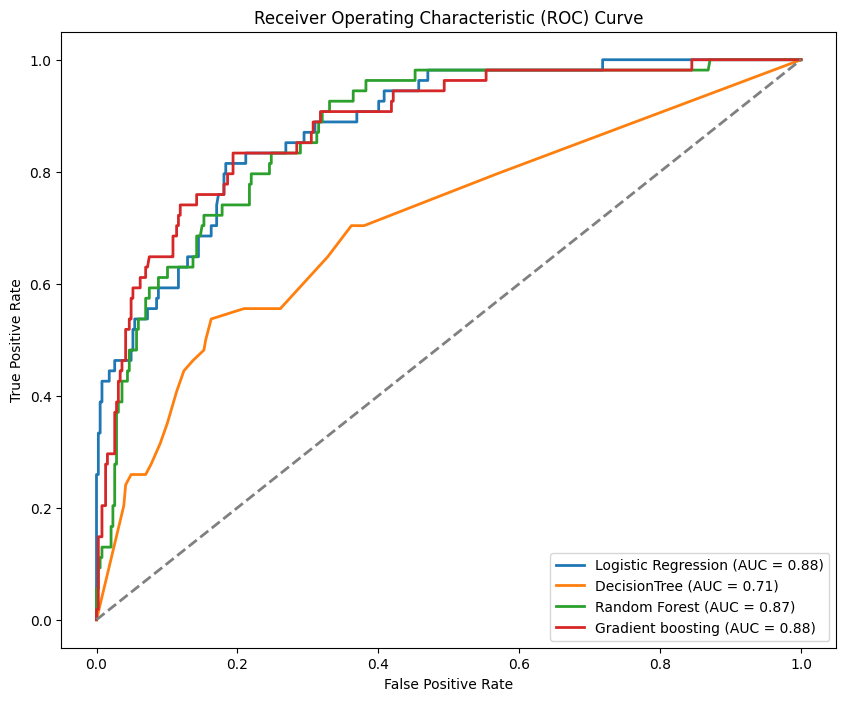

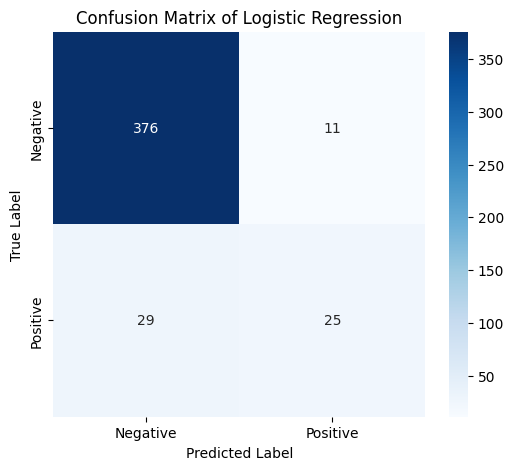

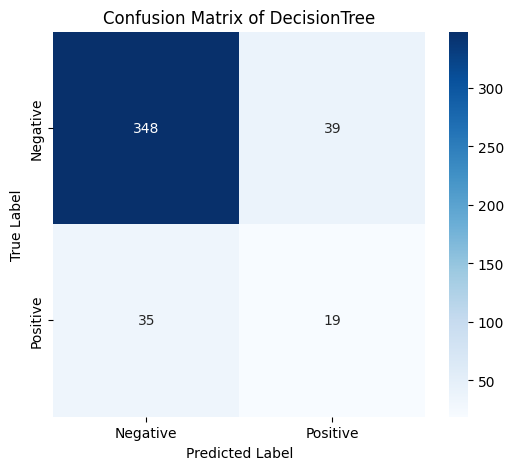

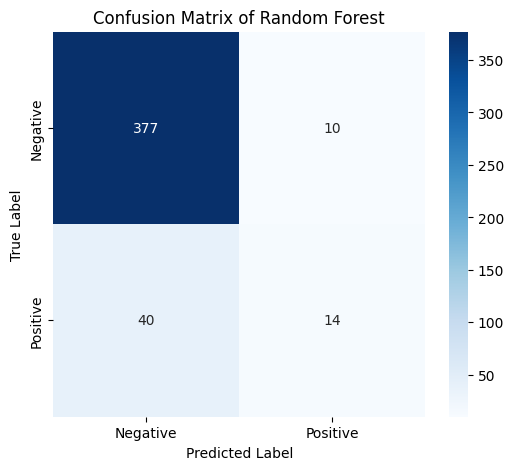

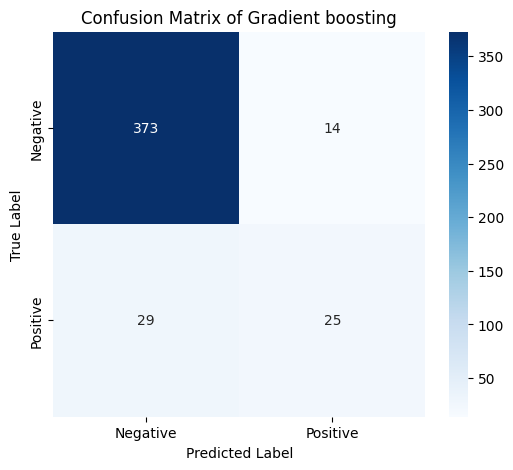

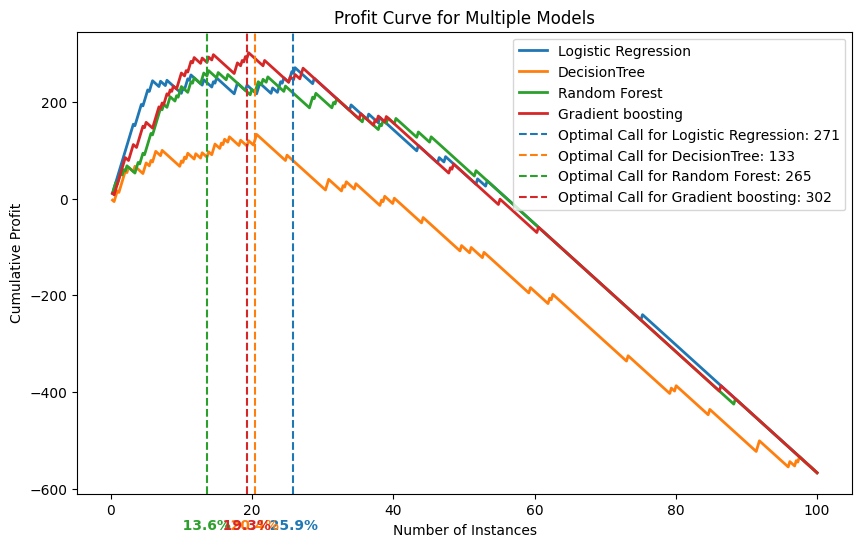

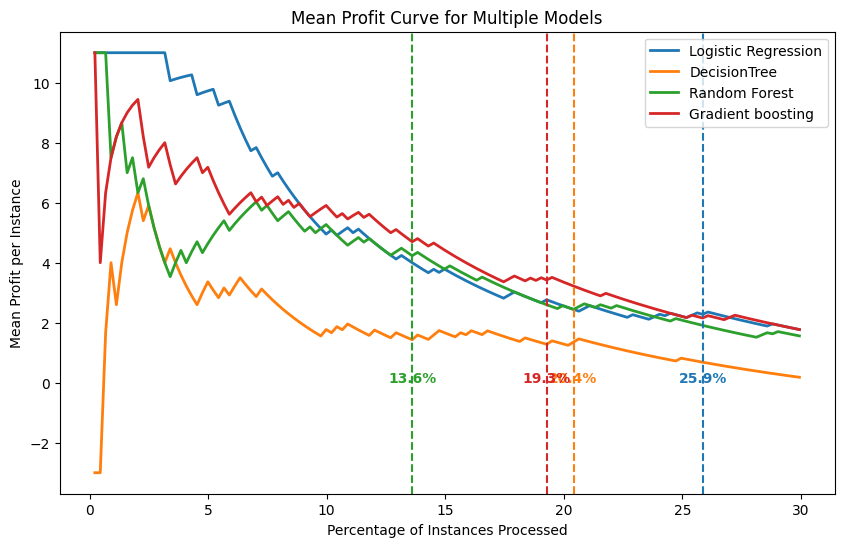

In [294]:
best_model = results["Random Forest"]["best_estimator"]
model_manager.assess_model(best_model)
model_manager.plot_roc_curves(results)
model_manager.plot_confusion_matrix(results)
model_manager.plot_profit_curve(results, 11, 3)
model_manager.mean_profit_curve(results, 11, 3)

In [295]:
profit_data = model_manager.data_profit_curve(results, 11, 3)
for model, profits in profit_data.items():
    print('='*50)
    print(f"Profit analysis for {model}")
    print('='*50)
    print(f"Max profit: {max(profits):.2f}")
    print(f"Mean of profit: {np.mean(profits):.2f}")
    print(f"Best percent selection: {(np.argmax(profits)/len(profits))*100:.2f}%")
    print('='*50)
    print('\n')

Profit analysis for Logistic Regression
Max profit: 271.00
Mean of profit: -30.08
Best percent selection: 25.85%


Profit analysis for DecisionTree
Max profit: 133.00
Mean of profit: -150.87
Best percent selection: 20.41%


Profit analysis for Random Forest
Max profit: 265.00
Mean of profit: -36.59
Best percent selection: 13.61%


Profit analysis for Gradient boosting
Max profit: 302.00
Mean of profit: -29.92
Best percent selection: 19.27%




In [296]:
models = ["Gradient boosting", "Logistic Regression"]
mod = {model: results[model] for model in models if model in results}

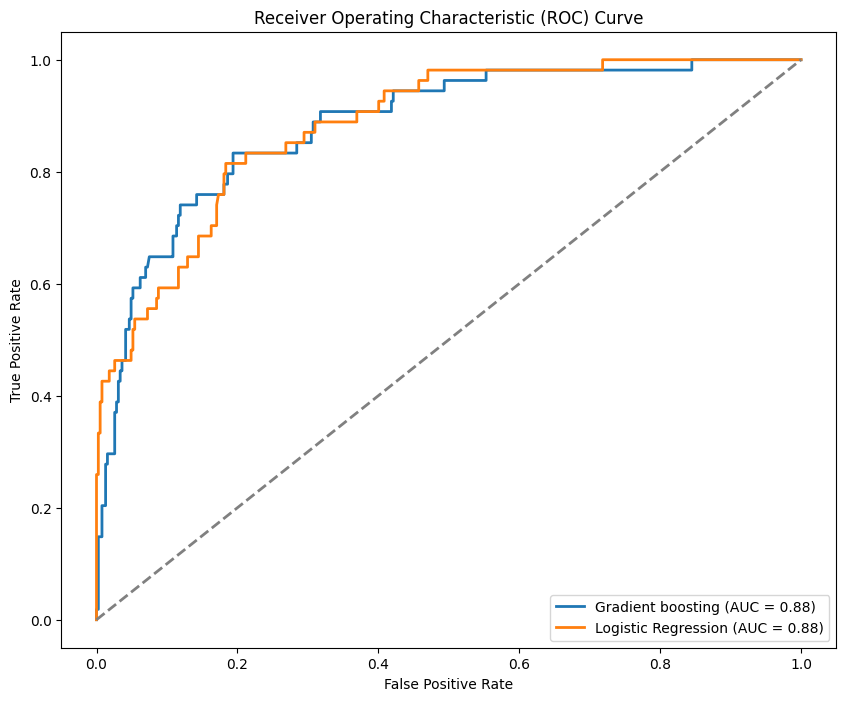

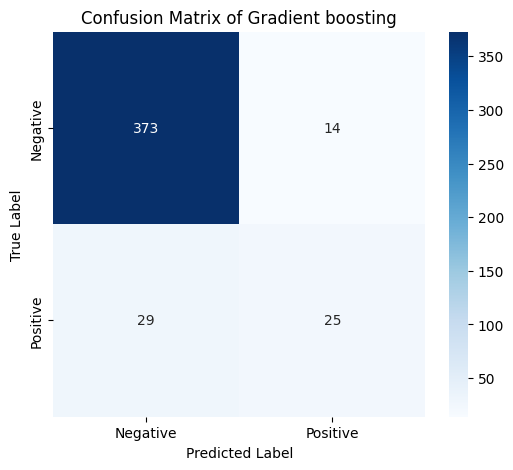

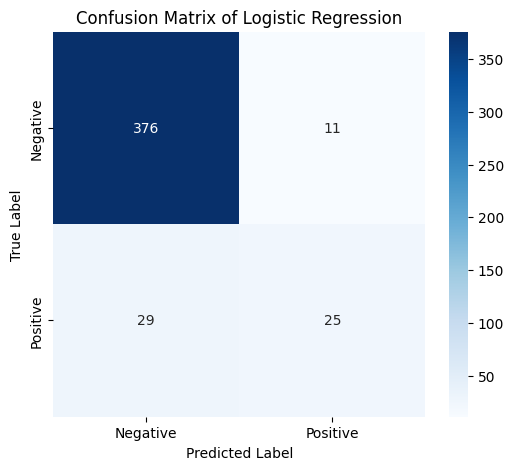

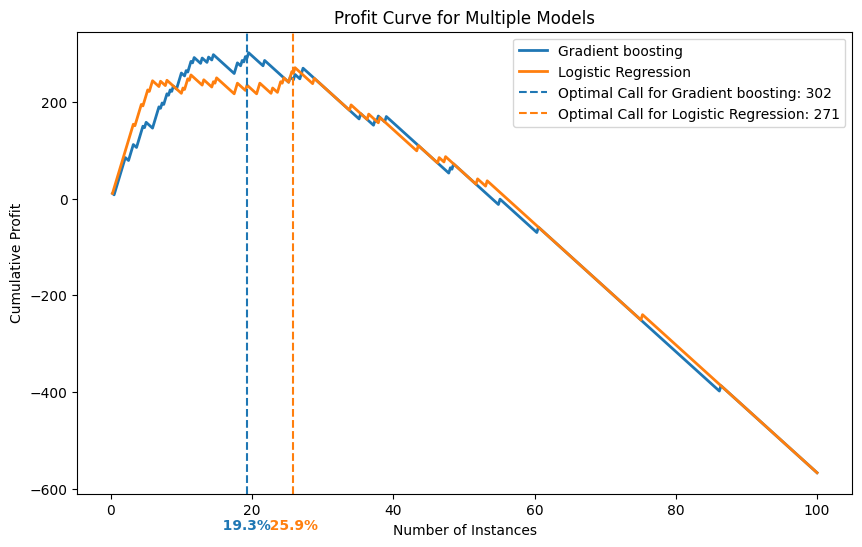

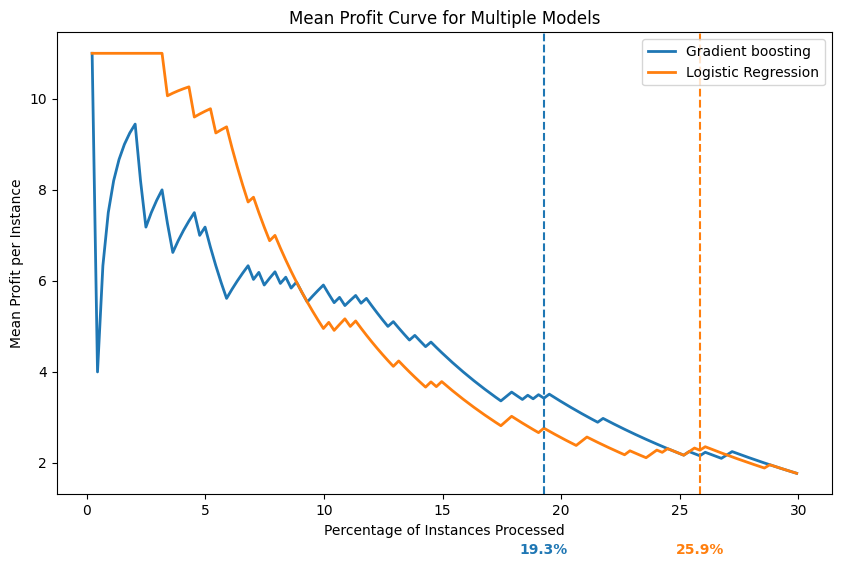

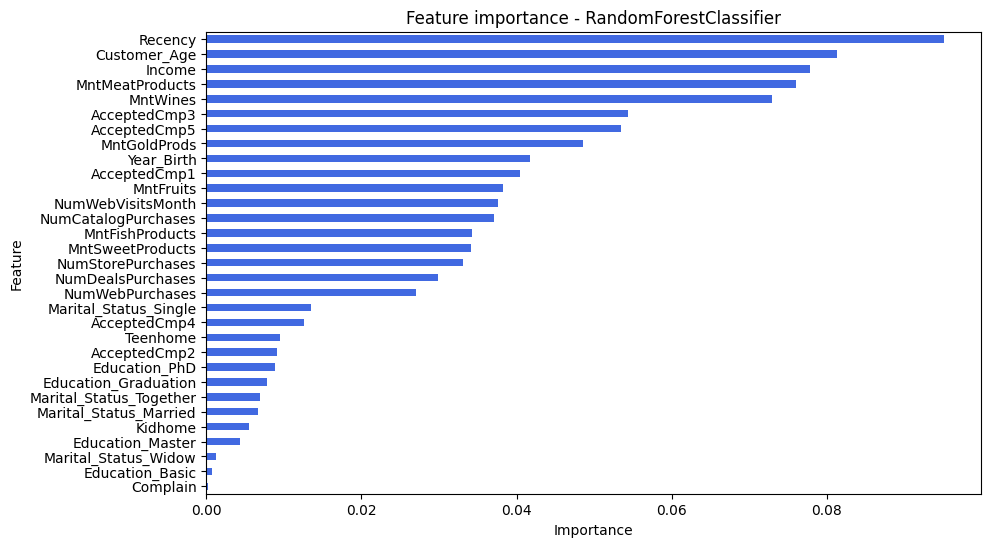

In [297]:
model_manager.plot_roc_curves(mod)
model_manager.plot_confusion_matrix(mod)
model_manager.plot_profit_curve(mod, 11, 3)
model_manager.mean_profit_curve(mod, 11, 3)

# Tree models
tree = results["Gradient boosting"]
model_manager.plot_feature_importance(best_model)
# model_manager.plot_decision_tree(best_model, max_depth=4)



In [261]:
profit_data = model_manager.data_profit_curve(mod, 11, 3)
for model, profits in profit_data.items():
    print('='*50)
    print(f"Profit analysis for {model}")
    print('='*50)
    print(f"Max profit: {max(profits):.2f}")
    max_profit = np.argmax(profits)
    div = np.arange(1, len(profits)+1)
    means = profits / div
    optimal_mean = means[max_profit]
    print(f"Optimal mean: {optimal_mean:.2f}")
    print(f"Mean of profit: {np.mean(profits):.2f}")
    print(f"Best percent selection: {(np.argmax(profits)/len(profits))*100:.2f}%")
    print('='*50)
    print('\n')

Profit analysis for Gradient boosting
Max profit: 269.00
Optimal mean: 3.24
Mean of profit: -36.43
Best percent selection: 18.59%


Profit analysis for Logistic Regression
Max profit: 271.00
Optimal mean: 2.36
Mean of profit: -30.08
Best percent selection: 25.85%




In [248]:
div = np.arange(1, 88)
div

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87])

In [ ]:
# SVC_model = SVC()

# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear'],  # Kernels , 'rbf', 'poly', 'sigmoid'
#     'degree': [2],  # for polynomial kernel
#     'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
#     'coef0': [0.0, 0.1, 0.5],  # for poly and sigmoid
#     'tol': [1e-3, 1e-4],  # tolerance to stop algo
# }

# grid_SVC = model_selection(SVC_model, param_grid=param_grid)
# asses_model(SVC_model)

In [ ]:
# knn_model = KNeighborsClassifier()

# knn_param_grid = {
#     'n_neighbors': [10, 15, 20],
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#     'metric': ['euclidean', 'manhattan'],
# }

# grid_knn = model_selection(knn_model, param_grid=knn_param_grid)
# asses_model(knn_model)